# CSC865: Machine Learning Extended Project
## Development of a multi-class text classifier
#### 
#### Name: Josh Cowper 
#### Student Number: c1053097
###### Date: 21/01/2022
#### 

# Context
Integration of Machine Learning (ML) practices into the Life Insurance industry can yield significant benefits by leveraging the vast amounts of user data generated by an increasingly digital-native customer-base (Nadkarni and Prügl, 2020; Maheshwari, 2021). With 95% of all future data growth predicted to be in unstructured formats such as free text, audio or web documents (Gantz and Reinsel, 2012), use of ML tools is critical to future organisational success; revealing insights either currently not available using traditional analytical techniques, or utilising greater complexity in modelling (Adnan and Akbar, 2019; Sarker, 2021).

Within Life Insurers, such as this author's client LifeInsurer, ML application can support fraud detection, insurance underwriting, experience customisation or new revenue-stream development amongst many potential opportunities (Malhotra and Sharma, 2018). However, at a functional level, ML can deliver direct benefits to existing teams by automating monotonous, manual tasks. In turn, this enables human resources to prioritise creative, high-value tasks.

This ML project will deliver a Proof of Concept (PoC) using publicly available data to represent automation of a key LifeInsurer process: multi-class classification of free text. Whilst labelled public data (Kaggle, 2021) is based upon Amazon reviews of pet products (Amazon, 2021), this framework will support LifeInsurer to categorise inbound customer queries, messages and call logs to best identify areas of interest, with the aim to better improve customer experience. Furthermore, this will also provide a solution to the existing manual review process, with the predictive model reducing human resource requirements and resultant subjectivity from the task. 

Throughout 2021, LifeInsurer has acquired a significant number of customer responses. Each of which has been manually assigned a topic. To leverage this stored domain knowledge, this PoC will utilise a Supervised Learning approach, using past examples of labelled data to train the model, and inform on future datasets. This will be directly applicable to LifeInsurer, given prevalence of labelled data and ease of access to the organisation.


## Process
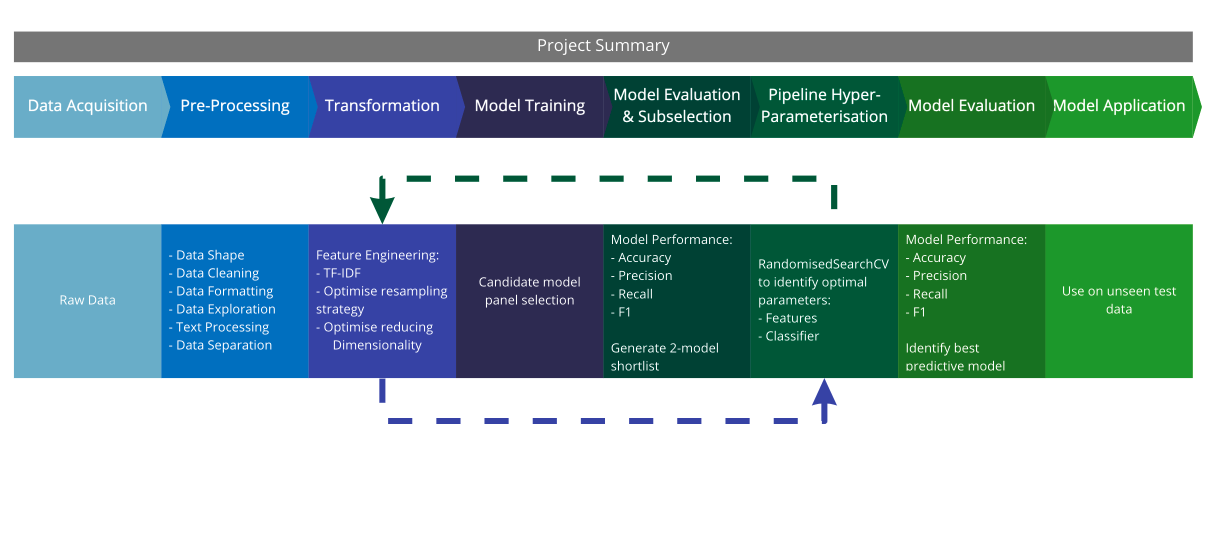
Exploration and iteration throughout this process will ensure that the most effective classification models and resultant parameters are selected. 5 Fold Cross Validation on the Training data will ensure that appropriate parameters are selected at each iterative stage, including: Feature selection and resampling technique to ensure that the best option is selected. This is further reinforced during hyper-parameterisation when the entire process is wrapped as a pipeline upon which RandomisedSearchCV of hyper-parameters occurs. Critically, this process of evaluation and iteration will use only training data, providing a final set of unseen test data for final evaluation. 

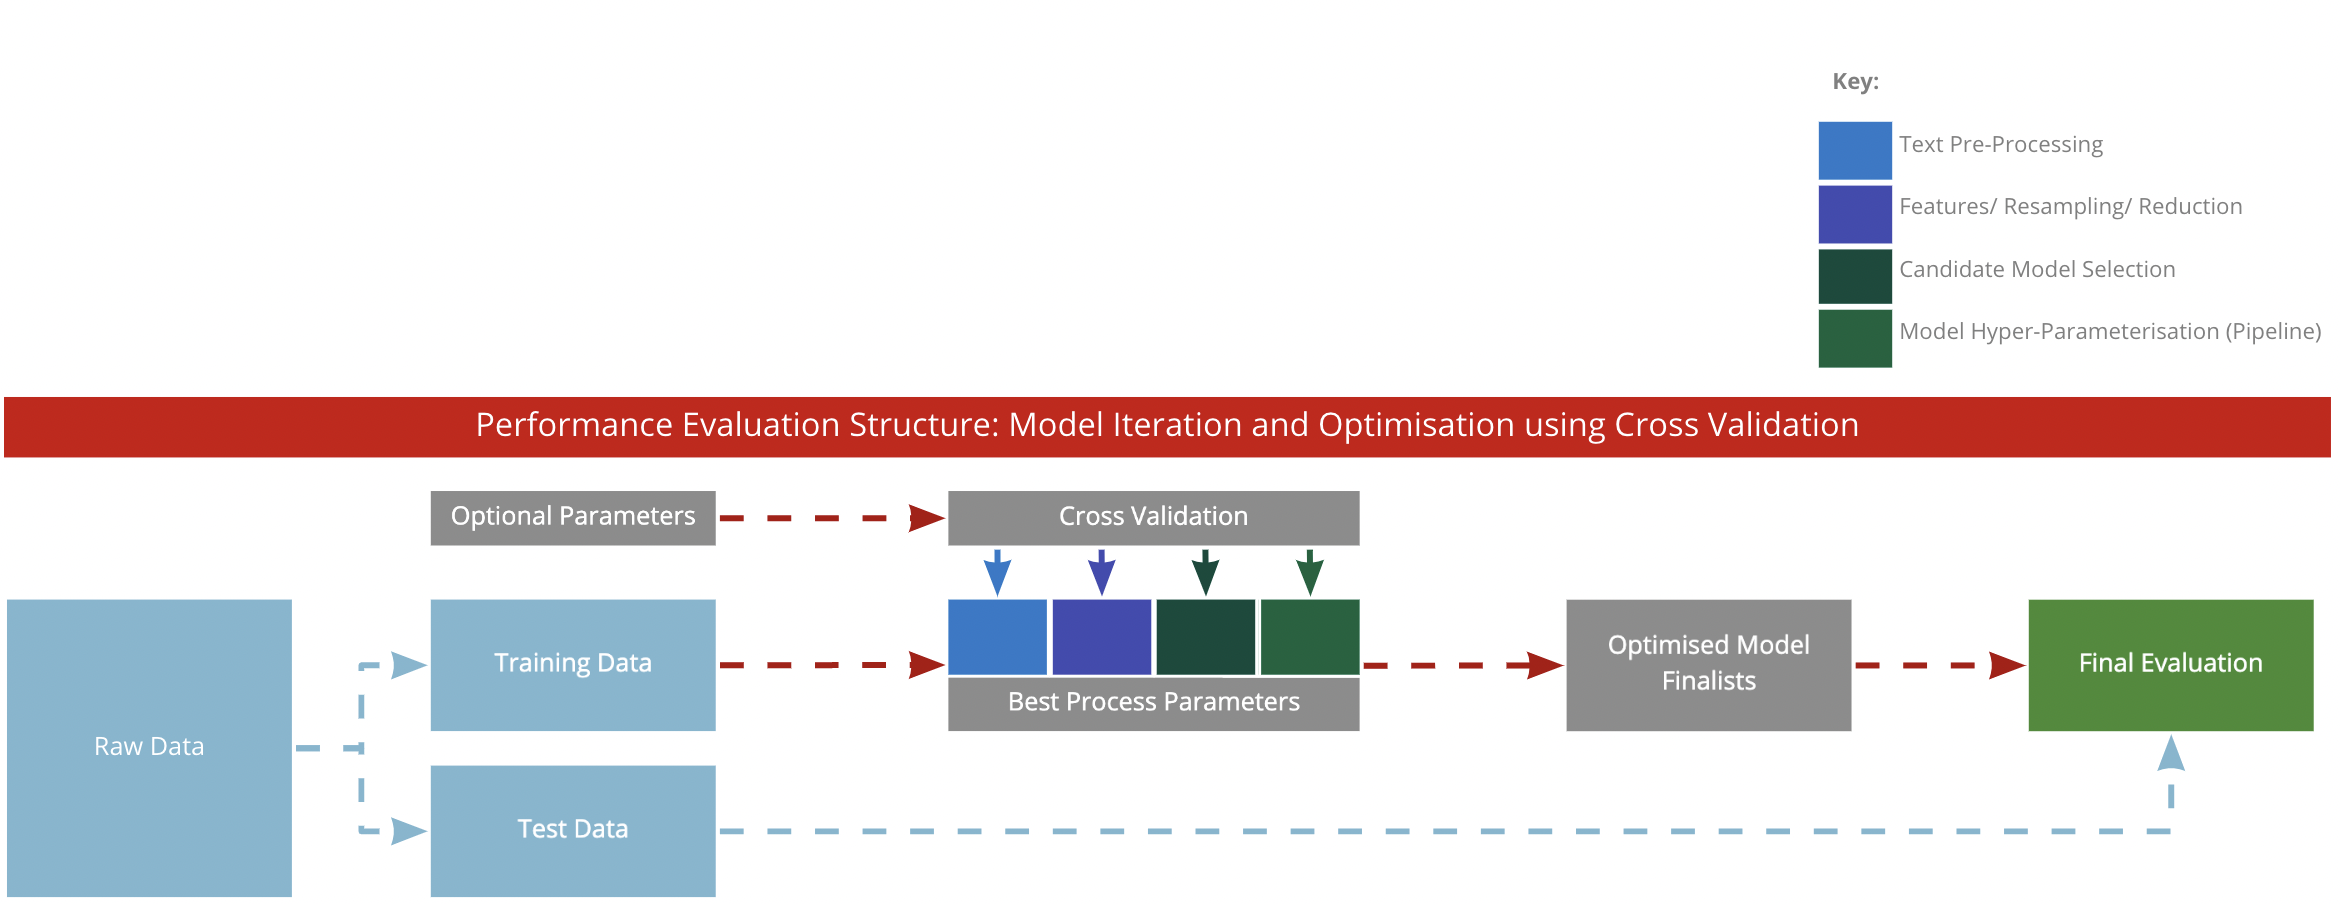





# Project: Multi-Class Text Classification Development



# Raw Data Acquisition

In [1]:
# libraries needed

# standard use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean,stdev
import joblib

# processing
from sklearn.preprocessing import LabelEncoder
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
import string
from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer # snowballstemmer preferred
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
import re
import pprint
import collections
import time

# models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB #best NB for textual data
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# tuning/ pipeline/ evaluation
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import Pipeline as Pipeline #imblearn pipeline preferred
import time
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize # allows to plot currves for multi-class (using ovevsall approach)
from sklearn.multiclass import OneVsRestClassifier

# resampling
import imblearn
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.pipeline import Pipeline as imbpipe, make_pipeline


import warnings
warnings.filterwarnings('ignore') # warnings ignored in submission only. Viewed in development


In [2]:
# dataset from github repo
# data files also provided to read in

url1 = 'https://raw.githubusercontent.com/jcowper7newc/multi-class-project/main/data/train.csv'
url2 = 'https://raw.githubusercontent.com/jcowper7newc/multi-class-project/main/data/valid.csv'

# read in as dataframes
train = pd.read_csv(url1) # read in local location if preferred
val = pd.read_csv(url2) # read in local location if preferred

print(train.shape)
print(val.shape)

# concat labelled data
df = pd.concat([train,val])
pd.set_option('display.max_columns',None)

print(df.shape) 
print(df.info())


(52057, 3)
(17353, 3)
(69410, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69410 entries, 0 to 17352
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      69410 non-null  int64 
 1   text    69410 non-null  object
 2   label   69410 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.1+ MB
None


## Raw Data Interpretation
Publicly available Pet review data is received as two pre-determined train and validation sets (Amazon, 2021; Kaggle 2021). Each contains three columns, row identifier and free text review alongside a class label determining which pet group it belongs to. There are no instances of missing or bad data which need to be addressed at this stage, however following PoC application at LifeInsurer, any instances will be addressed at this stage if required. Total available source data results in 69,410 Pet review entries available to the PoC, which will support model training, development and validation.

The pre-determined source datasets have been combined to provide greater control in creation of a test set to remain unseen. Initial breakdown indicated a 25% ratio of training to test data, whereas author preference is for a smaller test set to maximise minority class vocabulary examples within the training data. Following industry norms, 80% of data will be used for training models, whilst 20% will remain unseen for testing.


# Exploratory Data Analysis and Text Processing
Exploration of both label usgae and review content will inform PoC development. In particular, this process can refine initial data attributes, inform parameter or approach selection and indicate potential avenues for class differentiation pre-modeling.


In [81]:
# label distribution
summary = pd.DataFrame(df['label'].value_counts())
# summary['Pet Label'] = df['label'].unique()
summary['Frequency'] = pd.DataFrame(df['label'].value_counts())
summary['Proportion %'] = round(pd.DataFrame(df['label'].value_counts(normalize=True)),3)*100
summary = summary.drop(['label'],axis=1)

summary


,Frequency,Proportion %
dogs,37333,53.8
cats,24661,35.5
fish aquatic pets,4789,6.9
birds,1411,2.0
bunny rabbit central,760,1.1
small animals,456,0.7


Text(0.2, -0.35, 'Figure 1: Label Frequency of Pet Reviews')

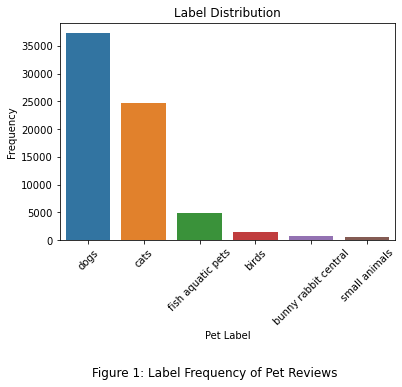

In [84]:
g = sns.barplot(x=summary.index.values,y='Frequency',palette = 'tab10',data=summary)
g.set_ylabel('Frequency')
g.set_xlabel('Pet Label')
g.set_title('Label Distribution')
g.despine=True
plt.xticks(rotation=45)
plt.figtext(0.2,-0.35,'Figure 1: Label Frequency of Pet Reviews',fontsize=12)


## Label distribution
Total dataset includes 6 distinct classes, however label distribution is heavily imbalanced. 90% of all data is compiled of cat and dog labels despite each class being of equal predictive importance. Furthermore, 3 classes each have under 2% representation.

Label imbalance could influence classifier predictive performance later on, through a bias corpus, limiting examples of minority vocabulary to be used within the TF-IDF process, and over-emphasis on certain labels. In addition, any model classification scoring should account for the likely bias on accuracy metrics due to weightings towards large classes. PoC development should determine the role that resampling has on model performance.

In [3]:
# create a partition to reduce data size whilst in development (select smaller fraction for faster development)
df = df.sample(frac=1,replace=False,random_state=10)


In [4]:
# remove unwanted words, characters, punctuation. standardise existing vocab
# pre-processing review text
df = df.rename(columns={'text':'review'})

stemmer = SnowballStemmer('english') # snowball word format preferred to Porter

def process_text(text):
# lowercase
    text = text.lower()
# special characters
    text = text.replace('[^\w\s]','')
    text = re.sub('[^a-zA-Z]',' ',text)
# tokenise/ punctuation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word.replace('  ',' ') for word in text]
# stopwords
    global stop
    stop = stopwords.words('english')
# stopwords extended following revision (training data seen only) 
    stop.extend(['get', 'read','review','recommend', 'also','buy','like', 'one', 'two', 'three', 'good',
                 'four', 'five',  'love', 'great', 'would',"i'v",'star','  ','amazon','use','product'])
    text = [word for word in text if word not in stop]
# word stemming
    text = [stemmer.stem(word) for word in text]
# remove single letter words
    text = [word for word in text if len(word)>1]
# join back into review
    text = " ".join(text)
    return text

df['clean_review'] = df['review'].apply(lambda x: process_text(x))
print('Number of Stopwords in use: '+ str(len(stop)))



Number of Stopwords in use: 201


In [8]:
# view stopwords
#stop

In [5]:
df['orig_review'] = pd.DataFrame(df['review'].apply(lambda x: len(x.split(' '))).astype(int))
df['proc_review'] = pd.DataFrame(df['clean_review'].apply(lambda x: len(x.split(' '))).astype(int))

# full text example of processing
print('Example text processing: \n')
print('Original review:  \n'
+ df.review[38953])

print('\n\nReview following processing:  \n'
+ df.clean_review[38953])
print('\n\n')


Example text processing: 

Original review:  
My 4 Siamese and 1 oriental all love the cat dancer i have to hide it when we go to bed they can't leave it and me alone they drag it all about the house following the leader wanting a play with it , when i play with them it drives them crazy they just can't get enough of it .Its money well spent, for a cat lover you will get full enjoyment out if this cat toy


Review following processing:  
siames orient cat dancer hide go bed leav alon drag hous follow leader want play play drive crazi enough money well spent cat lover full enjoy cat toy





In [7]:
# visualise processing impact

# per label category
avg_wc = df.groupby('label').mean().reset_index()
avg_wc= avg_wc[['label','orig_review','proc_review']]
avg_wc = avg_wc.rename(columns={'orig_review':'original review','proc_review':'processed review'})
avg_wc_piv = pd.melt(avg_wc, id_vars=['label'], value_vars=['original review','processed review'])


avg original review words: 85.0
avg processed review words: 37.0


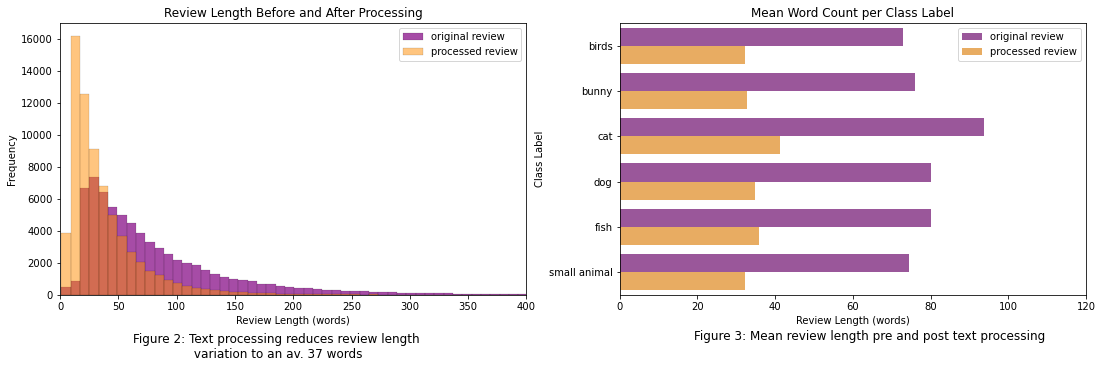

In [8]:
# totals
print('avg original review words: '+str(round(df['orig_review'].mean(),0)))
print('avg processed review words: '+str(round(df['proc_review'].mean(),0)))

fig, ax =plt.subplots(1,2,figsize=(15,5))



# classifier performance per component set
plt.subplot(1, 2, 1) # index 1
g = sns.histplot(df['orig_review'],binwidth=8,color='purple',alpha=0.7,legend=False)
g = sns.histplot(df['proc_review'],binwidth=8,alpha=0.5,color='darkorange',legend=False)
#fig.legend(labels=['original','processed'])
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.title('Review Length Before and After Processing')
plt.xlim(0,400)
plt.legend(labels=['original review','processed review'],loc='best')
plt.figtext(0.35,-0.05,'Figure 2: Text processing reduces review length\n variation to an av. 37 words',fontsize=12,
          horizontalalignment='center')

plt.subplot(1, 2, 2) # row 1, col 2 index 2
g = sns.barplot(
    data=avg_wc_piv,  y='label', x='value', hue='variable', alpha=.7,  palette=['purple','darkorange'])
#set_axis_labels('Mean Count','Pet Label')
plt.title('Mean Word Count per Class Label')
plt.legend(loc='best')
plt.xlim(0,120)
plt.xlabel('Review Length (words)')
plt.yticks(np.arange(len(df['label'].unique())),['birds','bunny','cat','dog','fish','small animal'])# shorten labels
plt.ylabel('Class Label')
plt.figtext(0.9,-0.00,'Figure 3: Mean review length pre and post text processing',
            fontsize=12,horizontalalignment='center')

plt.subplots_adjust(left=0.15,right=1.1) # improve chart spacing for label axis



Text(0.35, 0.09, 'Figure 4: Review length frequency pre and post text processing')

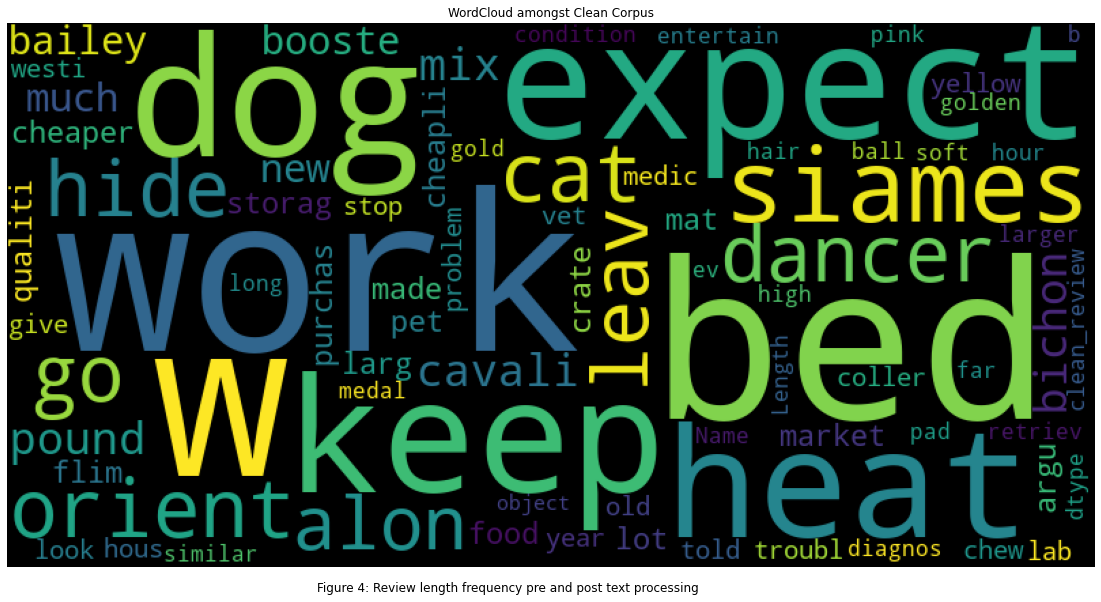

In [9]:
# wordcloud to visualise new clean_review corpus
clean_corpus = []
for word in df['clean_review'].str.split(' '):
  clean_corpus.extend(word)

wordcloud = WordCloud(random_state=10,width=800,height=400,stopwords=stop
                     ).generate(str(df['clean_review']))
plt.figure( figsize=(20,10) )

plt.imshow(wordcloud)
plt.axis('off')
plt.title('WordCloud amongst Clean Corpus')
plt.figtext(0.35,0.09,'Figure 4: Review length frequency pre and post text processing',fontsize=12)


In [10]:
# top words in corpus (all classes)
ct = collections.Counter(clean_corpus)
most_freq = pd.DataFrame(ct.most_common(10))
most_freq = most_freq.rename(columns={0:'Word',1:'Frequency'})
most_freq


,Word,Frequency
0,dog,53722
1,cat,37057
2,work,23163
3,use,17755
4,time,17717
5,toy,15382
6,well,14843
7,tri,13174
8,day,12320
9,litter,12154


## Text Processing Interpretation
#### Review length has changed significantly for each class, reducing approximately 44%.

Besides the removal of punctuation and numbers, all text is now lowercase. The benefit of which is the removal of excessive vocabulary to be stored within the word corpus and the reduction of likely vocabulary redundancy. For example, 'Cat' and 'cat' could be stored as distinct words, despite identical meaning. Word stemming also targets vocabulary redundancy through normalisation by reducing words to the initial stem which affixes prefix and suffix forms of each word. In addition, a total of 201 non-important words, termed stopwords have been excluded. These include common words which in the context of modelling convey no real meaning. For example, this could include 'the' or 'and'. 

Combined, this results in mean review length reducing by 44%; reducing from 85 to 37 per review. Distribution of review length per label class remains consistent, indicating that most reviews, regardless of class contain approximately the same level of information, in which to identify a classifier (Figure 2). The expected challenge will mainly focus upon the smaller number of documents available for those classes which are under-represented.

Furthermore, although only heuristic, Figure 4 quickly illustrates inclusion of relevant words. Class-specific examples such as pet breeds such as 'dog','cat','cavalier' or 'siamese' feature alongside more general pet terms like 'bed','toy' or 'litter'. Class-specific words will be investigated in more detail below.

A reduced corpus vocabulary should improve model classification performance due to reduced features and resultant complexity. However, this will be validated later within the process (Previous words have included 'amazon','buy' or 'review', which is not surprising given the data source - amazon reviews).

## Data Separation into Train and Test sets
Before further interrogation of class vocabulary, separation of data into Train and Test set provides a labelled set of data upon which a final predictive model can be compared. Performance of a predictive model which has used 'training' data indicates how well this model can generalise to new, external data which will be found in the 'real-world' situations.

Splitting must occur at this early stage to avoid undue data leakage from test data influencing the necessary iteration and improvement of features and model. Test leakage would result in over-optimistic final analysis upon the test data. 

Within the Text Processing stage,  this will ensure that test vocabulary does not feature within updated stopword list iterations. However, this is an equally important step for later model refinement and development as potential features and classifiers are assessed on their performance attributes. Whilst the model remains in development, Cross Validation will be used to improve the model before it is evaluated against this test data. Cross validation segments the training data; iterating until each k fold has acted as the test data. A mean test score is then produced upon which a decision can be made.



In [11]:
# splitting data and preparing for modelling for initial testing
# turn categorical label to number
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])
#display(df.groupby(['label'])['label'].count())
#display(df.groupby(['label_num'])['label'].count())

# label allocation
#print(df['label'].unique())
#print(df['label_num'].unique())

# Each categorical Class can now be represented with a number. A Dictionary ensures that these can be related back 
# for final class-level analysis within each Train and Test dataset.
label_dict ={'cats':2,'dogs':3,'birds':0,'bunny rabbit central':1,'fish aquatic pets':4,'small animals':5}

print('Labels encoded within dictionary as numeric: ')
label_to_num = pprint.pprint(label_dict)


Labels encoded within dictionary as numeric: 
{'birds': 0,
 'bunny rabbit central': 1,
 'cats': 2,
 'dogs': 3,
 'fish aquatic pets': 4,
 'small animals': 5}


In [12]:
X = df[['label','clean_review','review']] # label to be removed pre-modelling
y = df['label_num'].values

# data split train and test. Stratified to retain existing label distribution between original, train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,shuffle=True,stratify=y, random_state=10)

# confirming stratified split
lab = ['Dog','Cat','Fish','Birds','Bunny','Small Animals']
split = pd.DataFrame([lab,pd.value_counts(df['label_num'],normalize=True),
                      pd.value_counts(y_train,normalize=False),pd.value_counts(y_test,normalize=False)]).T
split = split.rename(columns={0:'Class Label',1:'Original Distribution %',2:'Train Size',3:'Test Size'})
print('Validation Size')

print('Training:' + str(X_train.shape) +'\nTesting: '+str( X_test.shape)+'\n\nStratified Label Distribution %:')
split


Validation Size
Training:(55528, 3)
Testing: (13882, 3)

Stratified Label Distribution %:


,Class Label,Original Distribution %,Train Size,Test Size
0,Dog,0.537862,29866,7467
1,Cat,0.355295,19729,4932
2,Fish,0.068996,3831,958
3,Birds,0.020328,1129,282
4,Bunny,0.010949,608,152
5,Small Animals,0.00657,365,91


## Class Vocabulary Exploration
Review content can be explored by investigating ngram frequency. Unigrams count individual words, whereas bigrams count two adjacent words within a review.

These can yield significant information for the processing process. For example, revealing further redundant words for exclusion, or interesting combinations. Furthermore, processed text will form the features used by predictive models, therefore, both unigrams, bigrams or both might be considered for use by the predictive classifier. 

In [13]:
# Class level vocabulary exploratory investigation

# top 10 words per label (train data)
# splitting each label into individual df
df_cat = X_train.loc[X_train['label']=='cats']
df_dog = X_train.loc[X_train['label']=='dogs']
df_bird = X_train.loc[X_train['label']=='birds']
df_bunny = X_train.loc[X_train['label']=='bunny rabbit central']
df_fish = X_train.loc[X_train['label']=='fish aquatic pets']
df_small = X_train.loc[X_train['label']=='small animals']

# ngram (1,1) exploration
def most_common(df,df2,topn):
  list = []
  name = df2.values[0]
  for word in df.str.split(' '):
    list.extend(word)
  ct = collections.Counter(list)
  sub_df = pd.DataFrame(ct.most_common(topn))
  sub_df = sub_df.rename(columns={0:name,1:'Freq'})

  return(sub_df)

cat = most_common(df_cat['clean_review'],df_cat['label'],10)
dog = most_common(df_dog['clean_review'],df_dog['label'],10)
bird = most_common(df_bird['clean_review'],df_bird['label'],10)
fish = most_common(df_fish['clean_review'],df_fish['label'],10)
bun = most_common(df_bunny['clean_review'],df_bunny['label'],10)
sml = most_common(df_small['clean_review'],df_small['label'],10)

label_word_freq = pd.concat([cat,dog,bird,fish,bun,sml],axis=1)
label_word_freq

,cats,Freq,dogs,Freq,birds,Freq,fish aquatic pets,Freq,bunny rabbit central,Freq,small animals,Freq
0,cat,26113,dog,35709,bird,943,tank,3227,cage,360,cage,317
1,litter,9514,work,9346,cage,776,filter,2664,rabbit,263,food,207
2,box,8281,toy,9131,perch,293,water,2071,pig,196,hamster,141
3,work,7528,time,7096,food,280,fish,2000,guinea,181,rat,120
4,dog,7229,collar,6679,time,237,work,1426,hay,175,pig,107
5,use,6511,use,6513,toy,228,gallon,1035,bunni,160,ferret,105
6,time,5825,well,6226,seed,215,use,968,bed,158,guinea,93
7,clean,4890,love,5636,well,213,aquarium,960,time,127,rabbit,92
8,well,4598,tri,5401,water,207,clean,771,small,125,clean,81
9,tri,4533,littl,4937,love,201,time,769,love,122,eat,73


In [25]:
# ngram(2,2) exploration - bigrams

def bigram_common(df1,df2 ,top_n):
    ct_vec = CountVectorizer(ngram_range=(2,2))
    list = []
    name = df2.values[0] # for df col name
    bigrams = ct_vec.fit_transform(df1) # matrix of bigrams
    count_word = bigrams.toarray().sum(axis=0) # count freq bigrams
    vocab = ct_vec.vocabulary_ # list of bigrams
    
    bigram_df = pd.DataFrame([(k,count_word[i]) for k,i in vocab.items()]
                            ).sort_values(by=1,ascending=False
                                         ).rename(columns={0:name,1:'Freq'}).reset_index(drop=True) 
    
    bigram_df = bigram_df.head(10)

    return bigram_df#.head(top_n)

cat_bi = bigram_common(df_cat['clean_review'],df_cat['label'],10)
dog_bi = bigram_common(df_dog['clean_review'],df_dog['label'],10)
bird_bi = bigram_common(df_bird['clean_review'],df_bird['label'],10)
fish_bi = bigram_common(df_fish['clean_review'],df_fish['label'],10)
bun_bi = bigram_common(df_bunny['clean_review'],df_bunny['label'],10)
sml_bi = bigram_common(df_small['clean_review'],df_small['label'],10)

label_bigram = pd.concat([cat_bi,dog_bi,bird_bi,fish_bi,bun_bi,sml_bi],axis=1)
label_bigram

,cats,Freq,dogs,Freq,birds,Freq,fish aquatic pets,Freq,bunny rabbit central,Freq,small animals,Freq
0,litter box,1795,year old,750,put togeth,37,gallon tank,181,guinea pig,102,guinea pig,48
1,work well,510,dog love,628,pet store,27,fish tank,125,easi clean,15,pet store,14
2,year old,443,work well,577,african grey,26,water chang,122,small anim,14,water bottl,13
3,cat love,401,month old,479,bird feeder,18,work well,84,pet store,10,timothi hay,9
4,everi day,370,dog food,456,work well,17,air pump,69,dwarf rabbit,8,easi clean,8
5,cat litter,316,small dog,432,everi day,17,make sure,61,water bottl,8,ferret food,8
6,clean litter,268,dog toy,325,sun conur,17,suction cup,61,work well,8,bought cage,6
7,make sure,261,well made,322,small bird,16,canist filter,59,timothi hay,8,rat food,6
8,cat food,248,pet store,298,easi clean,16,pet store,58,last week,8,litter box,6
9,cat box,222,larg dog,278,bird food,14,crystal clear,56,wood shave,7,clean cage,6


## Exploration Interpretation
#### Word frequency differentiates certain classes better than others. Different Ngram ranges yield useful insights. 
Top 10 unigrams indicate that for each class, vocabulary appears relevant. In particular, vocabulary for Bird and Fish classes are very distinct compared to other Pet Classes. This is not surprising given the unique habitat fish have in comparison to other Classes. However, there are some cross-class inclusions. For example, there are 3,809 instances of 'dog' within the Cat class. This could be because they share the same pet niche, or product owners are perhaps likely to own multiple pets, given a speciifc pet owned. Moreover, there is significant cross-over between Bunny and Small Animal, although expected given the overlap in animals each class contains. Without domain knowledge assumptions can be made, but further interrogation of label allocation and reviewer source would enhance knowledge of these relationships. For the purposes of this PoC, further investigation is limited, however expanded to real-world settings at LifeInsurer, this would be pursued.

Top 10 Bigrams indicate that litter is a common priority for Cat owners whereas Dog owners are more focussed upon food and play. Again, Bird and Fish retain unique popular vocabulary, whilst Bunny and Small Animal have similar vocabularies, although some rabbit specific vocabulary is more prominent within Bunny, such as breeds ' Dwarf'. Small Class sizes for these two groups is not beneficial, limiting vocabularly options further; reducing possible differentiators between classes.

Both Unigrams and Bigrams appear useful. The both options shall be considered for use within the final classifier model during hyper-parameterisation.

# Feature Generation and TF-IDF
Textual data cannot be analysed directly by classifier models. Therefore, feature extraction is required to transform the textual data contained within each review document into features which can be interpreted. A common approach used is Bag-of-Words (BOW), which transforms each unique word within total corpus vocabulary into a feature. Values recorded per feature represent frequency of occurrence per document. However, frequency alone could over-emphasise words which are more frequent in general use and ignore importance of infrequently used words, despite potential significance within specific documents or minority classes. To address this Term Frequency Inverse Document Frequency (TF-IDF) can be used. Instead of frequency, TF-IDF scores increase proportionally relative to word frequency within each document; capturing words important to relevant to each document’s specific context (Qaiser and Ali, 2018; Nair, 2020). As a result, 83% of text-based recommender systems currently utilise TF-IDF (Beel et al., 2016). 


In [14]:
# feature text
# preparing clean review and original review datasets to investigate if a cleaned corpus improves 
# classifier predictive performance

# drop label from feature modelling (only focussed on review bodies)
#train
orig_review_train = X_train['review'].astype(str) # test to see if pre-processing improves baseline
clean_review_train = X_train['clean_review'].astype(str)

# test
orig_review_test = X_test['review'].astype(str)
clean_review_test = X_test['clean_review'].astype(str)


In [15]:
# optimising at Pipeline stage, currently using defaults
#  Will pass vocab from training set as parameter to test data

# original review text
tf_idf_orig_1 = TfidfVectorizer()

tf_idf_clean_1 = TfidfVectorizer()

# features to use for training set
X_train_clean = tf_idf_clean_1.fit_transform(clean_review_train)
X_train_orig = tf_idf_orig_1.fit_transform(orig_review_train)
y_train

print('Training Corpus Feature Generation:')
print('TF-IDF Features generated:  '+ str(X_train_orig.shape[1])+' as standard pre-optimisation (original text)')
print('TF-IDF Features generated:  '+ str(X_train_clean.shape[1])+' as standard pre-optimisation (processed text)')


# applying training corpus to validation set
tf_idf_orig_2 = TfidfVectorizer(vocabulary=tf_idf_orig_1.vocabulary_)
tf_idf_clean_2 = TfidfVectorizer(vocabulary=tf_idf_clean_1.vocabulary_)

X_test_orig = tf_idf_orig_2.fit_transform(orig_review_test)
X_test_clean = tf_idf_clean_2.fit_transform(clean_review_test)

X_train_clean.shape


Training Corpus Feature Generation:
TF-IDF Features generated:  42883 as standard pre-optimisation (original text)
TF-IDF Features generated:  27164 as standard pre-optimisation (processed text)


(55528, 27164)

## Model Baseline and Text Processing Efficacy using Naive Bayes
To establish the benefit of text processing, a baseline exercise will be conducted to assess performance. Multinomial Naive Bayes is a suitable candidate classifier given lack of assumptions, efficiency and fast execution. 

Performance will be assessed using 5 fold Cross Validation. Whilst total accuracy will be provided, class accuracy is more informative. Imbalanced class distribution over-scores true accuracy due to the increased likelihood of guessing the most common class. The best performing feature-set, either on processed or raw data, will be used further in the development of the PoC.


In [16]:
# MultinomialNB baseline (no tuning)
# K5 CV (istead of train-test)
NB = MultinomialNB()
skf=StratifiedKFold(n_splits=5, shuffle=True,random_state=10)


In [316]:
# MultinomialNB baseline (no tuning)

# confirming that default behaviour for cross_val_score uses a stratified CV split
# manual stratified fold
nb_skf_acc = []
for train_ind, test_ind in skf.split(X_train_orig, y_train):
  x_train_fold, x_test_fold = X_train_orig[train_ind], X_train_orig[test_ind]
  y_train_fold, y_test_fold = y_train[train_ind],y_train[test_ind]
  NB.fit(x_train_fold,y_train_fold)
  nb_skf_acc.append(NB.score(x_test_fold,y_test_fold))

# default cross_val_score stratification score/ when specifying cv type
nb_orig_score = cross_val_score(NB,X_train_orig,y_train,cv=10,scoring='accuracy')
nb_orig_skf_score = cross_val_score(NB,X_train_orig,y_train,cv=skf,scoring='accuracy')

# CV outputs (orig text test)
print('cross val score default: ', nb_orig_score.mean())
print('manual skf score: ', mean(nb_skf_acc))
print('cross val score with skf: ',nb_orig_skf_score.mean())

print('\n')
print('5 Fold Accuracy for Original Text: ', nb_orig_skf_score.mean())
y_pred = cross_val_predict(NB, X_train_orig,y_train,cv=skf)
matrix = confusion_matrix(y_train,y_pred)

print('Class Accuracy: ',(matrix.diagonal()/matrix.sum(axis=1)).round(3))
nb_clean_skf_score = cross_val_score(NB,X_train_clean,y_train,cv=skf,scoring='accuracy')
nb_clean_skf_f1 = cross_val_score(NB,X_train_clean,y_train,cv=skf,scoring='f1_macro')

print('\n5 Fold Accuracy for Cleaned Text: ', nb_clean_skf_score.mean())
print('5 Fold F1 for Cleaned Text: ', nb_clean_skf_f1.mean())

y_pred = cross_val_predict(NB, X_train_clean,y_train,cv=skf)
matrix = confusion_matrix(y_train,y_pred)
print('Class Accuracy: ',(matrix.diagonal()/matrix.sum(axis=1)).round(3))

# cleaned text provides better accuracy
# further predictor information 
print('\n\nClean, Processed Text: Classification Report')
print(matrix)
print('\n',classification_report(y_train,y_pred))


cross val score default:  0.7389424726152127
manual skf score:  0.7331436390500999
cross val score with skf:  0.7331436390500999


5 Fold Accuracy for Original Text:  0.7331436390500999
Class Accuracy:  [0.001 0.    0.578 0.961 0.156 0.   ]

5 Fold Accuracy for Cleaned Text:  0.7642450916885973
5 Fold F1 for Cleaned Text:  0.3571837779422504
Class Accuracy:  [0.016 0.    0.642 0.944 0.403 0.   ]


Clean, Processed Text: Classification Report
[[   18     0   377   730     4     0]
 [    0     0    84   524     0     0]
 [    0     0 12675  7041    13     0]
 [    0     0  1649 28199    18     0]
 [    0     0  1223  1063  1545     0]
 [    0     1    48   315     1     0]]

               precision    recall  f1-score   support

           0       1.00      0.02      0.03      1129
           1       0.00      0.00      0.00       608
           2       0.79      0.64      0.71     19729
           3       0.74      0.94      0.83     29866
           4       0.98      0.40      0.57   

## Text Processing Interpretation
#### Cleaning process increases model performance.
Baseline classification accuracy is strong at 73% without text pre-processing. However, text processing improves accuracy score to 76% despite including 15,719 fewer features, suggesting that improved feature parsimony enhances model performance. 

Accuracy is not an effective performance metric to assess total model performance however. Over-representation of Cat and Dog labels within the training data skew model training to classes best represented; presenting an over-optimistic image. This is supported by an F1 score of 36%, harmonious metric of Precision and Recall ability, which better measures performance. Interrogating Class accuracy scores reveal significant improvements in minority class classification following text processing. In particular, Fish (Class 4) has increased from 16% to 40% accuracy. Bunny Class remains poorly classified regardless of text processing. Further model development will utilise the clean, processed text corpus.

Further analysis of the clean, processed text provides additional performance metrics. High precision for minority classes indicates limited False Positive generation, with the smallest True Positives recorded, most likely for very obvious documents. This is supported by very low recall, indicating significant False Negative for each label. 

Clearly existing data does not generalise well to each Class Label, with predominant predictive selection weighted to majority class selection. Resampling the training data could improve model performance by rebalancing label distribution and therefore better classification of minority classes. Different methodologies will be assessed. 

# Resampling
Three Resampling techniques will be used to adjust class label distribution with the aim of balancing model training to respect each label equally, and therefore predictive ability. Increase in representation of minority classes will be prioritised with two oversampling approaches due to small sample availability. A manual over and undersampling approach will also be used across all classes to assess impact of a smaller training dataset. If this is viable it could offer significant performance benefits due to the reduced dimensionality and ongoing processing needed. 

Resampling Strategies:
- SMOTE
- ROS (Random Over Sampler)
- Manual Resampling (over and undersampling)

Both ROS and SMOTE require numeric data for oversampling, therefore, this must follow feature generation. Manual resampling does not, however to standardise approaches this will also occur following TF-IDF.

In [17]:
# BEST RESAMPLING TECHNIQUE - 5k CV
# SMOTE, ROS or undersample


# clean text
skf=StratifiedKFold(n_splits=5, shuffle=True,random_state=10) # reducing CV to 5 due to oversampling size



# SMOTE
smt = SMOTE(random_state=10,sampling_strategy='not majority') # oversamples minority classes
smt_x_clean, smt_train_y = smt.fit_resample(X_train_clean,y_train)
#print('SMOTE Resampled Label distribution:\n',pd.value_counts(smt_train_y))

smt_acc = cross_val_score(NB, smt_x_clean, smt_train_y,cv=skf,scoring='accuracy')
smt_f1 = cross_val_score(NB, smt_x_clean, smt_train_y,cv=skf,scoring='f1_macro')

smt_pred = cross_val_predict(NB,smt_x_clean,smt_train_y,cv=skf)
#print('\nSMOTE Accuracy: ',smt_acc.mean())
#print('SMOTE F1: ',smt_f1.mean())
smt_matrix = confusion_matrix(smt_train_y,smt_pred)
#print('Class Acc: ',smt_matrix.diagonal()/smt_matrix.sum(axis=1))

#print(classification_report(smt_train_y,smt_pred))



# Random Over Sampling

ros = RandomOverSampler(random_state=10,sampling_strategy='not majority')
ros_x_clean, ros_train_y = ros.fit_resample(X_train_clean,y_train)
#print('\nROS Resampled Label distribution:\n',pd.value_counts(ros_train_y))

ros_acc = cross_val_score(NB, ros_x_clean, ros_train_y,cv=skf,scoring='accuracy')
ros_f1 = cross_val_score(NB, ros_x_clean, ros_train_y,cv=skf,scoring='f1_macro')

ros_pred = cross_val_predict(NB,ros_x_clean,ros_train_y,cv=skf)
#print('\nROS Accuracy: ',ros_acc.mean())
#print('ROS F1: ',ros_f1.mean())
ros_matrix = confusion_matrix(ros_train_y,ros_pred)
#print('Class Acc: ',ros_matrix.diagonal()/ros_matrix.sum(axis=1))

#print(classification_report(ros_train_y,ros_pred))


# Random resampling: Manual Over/ Under

resample_n= 2000 # random over/ undersamples all classes to 2000 docs
#print('\n')

re_dog = df_dog.sample(resample_n)
re_cat = df_cat.sample(resample_n,replace=True)
re_fish = df_fish.sample(resample_n,replace=True)
re_birds = df_bird.sample(resample_n,replace=True)
re_sml = df_small.sample(resample_n,replace=True)
re_bun = df_bunny.sample(resample_n,replace=True)


resample = pd.concat([re_dog,re_cat,re_fish,re_birds,re_sml,re_bun])

resample['label'].value_counts()

X_train_clean_review = resample['clean_review'].astype(str)
resample_tfidf = resample['clean_review'].astype(str)
resample_tfidf = tf_idf_clean_2.fit_transform(resample_tfidf)
resample_tfidf # n 55524 (9254 * 6) # observe performance and can increase if possible

# Resplitting resampled data and prepare for modelling
LE = LabelEncoder()
resample['label_num'] = LE.fit_transform(resample['label'])

X_train_re = resample_tfidf
y_train_re = resample['label_num'].values
X_train_re #55524 x 30928


# improvement vs B baseline?
#print('Resample to equal values per K: ' ,resample_n) 
#print('Manual Resample Label distribution:\n',pd.value_counts(y_train_re))

acc = cross_val_score(NB, X_train_re, y_train_re,cv=skf,scoring='accuracy')
f1 = cross_val_score(NB, X_train_re, y_train_re,cv=skf,scoring='f1_macro')


pred = cross_val_predict(NB,X_train_re, y_train_re,cv=skf)
#print('\nManual Resample Accuracy: ',acc.mean())
#print('Manual Resample F1: ',f1.mean())
matrix = confusion_matrix(y_train_re,pred)
#print('Class Acc: ',matrix.diagonal()/matrix.sum(axis=1))

#print(classification_report(y_train_re,pred))


In [18]:
# Resample class sizes
X_train['label_nu'] = LE.fit_transform(X_train['label'])
lab = ['Dogs','Cats','Fish','Birds','Bunny','Small Animals']

resample_option_df = pd.DataFrame(
                        [lab,X_train['label_nu'].value_counts(),
                                pd.value_counts(smt_train_y),
                                   pd.value_counts(ros_train_y),
                                  resample['label_num'].value_counts()
                                   
]).T
resample_option_df = resample_option_df.rename(
    columns={0:'Class Label',1:'Original',2:'SMOTE',3:'ROS',4:'Manual Resample'})


print('Resample Class sizes')
resample_option_df = resample_option_df#.sort_values(by='Original',ascending=False)


resample_option_df


Resample Class sizes


,Class Label,Original,SMOTE,ROS,Manual Resample
0,Dogs,29866,29866,29866,2000
1,Cats,19729,29866,29866,2000
2,Fish,3831,29866,29866,2000
3,Birds,1129,29866,29866,2000
4,Bunny,608,29866,29866,2000
5,Small Animals,365,29866,29866,2000


In [19]:
# overall resampling scores
score = ['accuracy','precision_macro','recall_macro','f1_macro']
smt_score = cross_validate(NB,smt_x_clean,smt_train_y, cv=skf, scoring = score)
ros_score = cross_validate(NB,ros_x_clean,ros_train_y, cv=skf, scoring = score)
manual_score = cross_validate(NB,X_train_re,y_train_re, cv=skf, scoring = score)
original_score = cross_validate(NB,X_train_clean,y_train, cv=skf, scoring = score)

resample_dict = {'Original':original_score,'SMOTE':smt_score,'ROS':ros_score,'Manual Resample':manual_score}

def best_resample(resdict):
  name,acc,prec,rec,f1 = [],[],[],[],[]
  for n, p in resdict.items():
    name.append(n)
    acc.append(p['test_accuracy'].mean())
    prec.append(p['test_precision_macro'].mean())
    rec.append(p['test_recall_macro'].mean())
    f1.append(p['test_f1_macro'].mean())
    df = pd.DataFrame([name,acc,prec,rec,f1]).T
    df = df.rename(columns={0:'Resample Method',1:'Accuracy',2:'Precision',3:'Recall',4:'F1'})


  return df

resample_df = best_resample(resample_dict)

resample_df.sort_values(by=['F1'],ascending=False)

,Resample Method,Accuracy,Precision,Recall,F1
1,SMOTE,0.907386,0.906183,0.907386,0.906655
2,ROS,0.893614,0.892657,0.893614,0.89297
3,Manual Resample,0.84825,0.849007,0.84825,0.847923
0,Original,0.763182,0.576353,0.333635,0.356215


In [20]:
# SMOTE scored highest scores. See classification report for additional info
# more SMOTE details
print('SMOTE resampling technique scored highest Accuracy and F1\nSMOTE Accuracy: ',smt_acc.mean())
print('\nFurther details:')
print(classification_report(smt_train_y,smt_pred))

SMOTE resampling technique scored highest Accuracy and F1
SMOTE Accuracy:  0.9073863202509337

Further details:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     29866
           1       0.94      0.96      0.95     29866
           2       0.82      0.78      0.80     29866
           3       0.82      0.81      0.81     29866
           4       0.97      0.97      0.97     29866
           5       0.95      0.97      0.96     29866

    accuracy                           0.91    179196
   macro avg       0.91      0.91      0.91    179196
weighted avg       0.91      0.91      0.91    179196



## Resampling Technique Interpretation
#### SMOTE delivers the highest scores in both Accuracy and F1, with mean classification accuracy of 91% from Cross Validation. 

Performance is 1% better in contrast to ROS, and 5% better than undersampling of majority classes. 91% F1 (increasing from 35% baseline) indicates that predictive false positives and false negatives have reduced, and classification is much more effective across all classes.

In comparison to the two alternative techniques, ROS and manual undersampling attempts. SMOTE synthesises new examples of each minority classes based on 5 nearest class neighbours within pre-existing documents, improving in-class variety and feature relationships. Furthermore, artificial examples may help to mitigate the effects of overfitting which are likely to occur, given the vast oversampling occurring (for example, Small Animals  has increased by a ratio of 81 times, from 365 to 29,866, a vast oversampling ratio.

SMOTE oversampling will be used as the resampling technique of choice for model prediction. However, outside of PoC when using LifeInsurer customer data, suitability of sampling strategy must be assessed to mitigate high dimensionality issues.

# Feature Reduction
Despite corpus size reducing 37% following processing, there still remain 27,011 words used in modelling. Some of these will be redundant. 

Feature numbers can be limited directly within TF-IDF, however, limitation based upon frequency ensures permament information loss even if less common features are important to prediction. An alternative is Latent Semantic Analysis (LSA). This dimensionality reduction technique uses Singular Value Decomposition (TruncatedSVD within PoC due to sparse optimisation) to reduce total feature number through matrix factorisation; decreasing vocabulary synonymy and polysemy (Manning, Raghavan and Schütze, 2008; Korzycki, Gatkowska and Lubaszewski, 2017). Transformation into eigenvector dimensions enable the initial features which provided the greatest variance to be condensed; removing highly correlated features and ensuring that only the most important dimensions are utilised (SciKit-Learn, 2021). 

The benefits of which should improve overall predictive performance by improving model parsimony. Furthermore, computational performance should be improved due to reduced feature space size. 

Various eigenvector numbers (components) will be considered to identify the optimal balance between feature reduction and classifier performance. 


In [21]:
# renaming for ease

X_train_re = smt_x_clean
y_train_re = smt_train_y

X_test = X_test_clean
y_test.shape


print(X_train_re.shape,y_train_re.shape) # X_train oversampled with SMOTE 
print(X_test.shape,y_test.shape) # test data


(179196, 27164) (179196,)
(13882, 27164) (13882,)


In [180]:
# Performance summary table at different component values


# target component range
comps = [1,10,50,100,200,300,400,500]

# function - measure component classifier performance
def best_component(comps, xtrain,ytrain): # refrain from multiple runs - takes long time
    comp, var,gen,acc, f1 = [],[],[],[],[]
    for c in comps:
        start = time.time()
        # labelling info
        svd = TruncatedSVD(n_components=c, random_state=10,n_iter=10)
        svd.fit(xtrain)
        comp.append(c)
        v = svd.explained_variance_ratio_.sum()
        var.append(v)

        # transform for preds
        xtra = svd.fit_transform(xtrain)
        scale = MinMaxScaler()
        xtra = scale.fit_transform(xtra)
        end = time.time()
        tot = end-start


        # predictions
        mb = MultinomialNB()
        acc_score = cross_val_score(mb, xtra,ytrain,cv=skf,scoring='accuracy').mean()
        f1_score = cross_val_score(mb, xtra,ytrain,cv=skf,scoring='f1_macro').mean()
        acc.append(acc_score)
        f1.append(f1_score)
        gen.append(tot)
        # join
        df = pd.DataFrame([comp,var,acc,f1,gen]).T
        df = df.rename(columns={0:' n Components',1:'Cum Var',2:'Accuracy',3:'F1',4:'Generation time (s)'})
        
    return df
        
component_df = best_component(comps,X_train_re,y_train_re)       

component_df

,n Components,Cum Var,Accuracy,F1,Generation time (s)
0,1.0,0.019412,0.166661,0.047618,2.328275
1,10.0,0.132945,0.538349,0.554495,3.330941
2,50.0,0.253072,0.678927,0.674941,9.706591
3,100.0,0.329820,0.691020,0.687810,22.337048
4,200.0,0.430937,0.705663,0.703948,44.309922
5,300.0,0.501971,0.715239,0.714107,69.060220
6,400.0,0.556624,0.720535,0.719412,95.803532
7,500.0,0.600969,0.727371,0.726361,129.690546


Text(0.22, -0.05, 'Figure 5: Dimensionality reduction to various components numbers and resultant variance and performance')

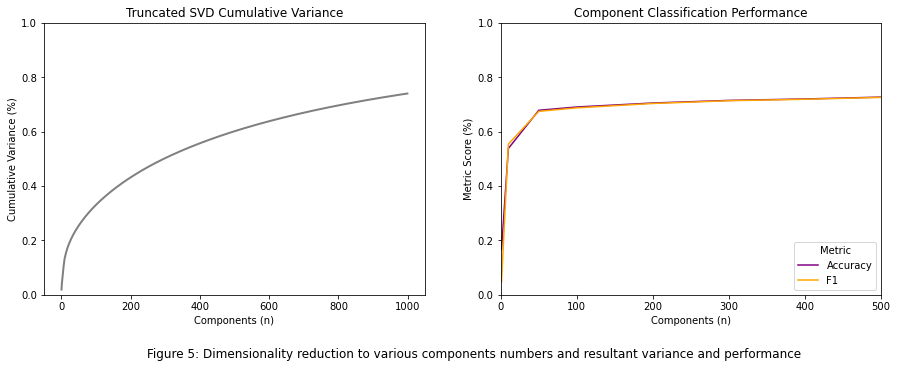

In [182]:
# Visualising SVD dim reduction accuracy at different component numbers
x = [1,10,50,100,200,300,400,500]
svd = TruncatedSVD(n_components=1000, random_state=10,n_iter=10)
svd.fit_transform(X_train_re) # fit to train


# component variance proportion, 
fig, ax =plt.subplots(1,2,figsize=(15,5))

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.ylim(0,1)
plt.plot(np.cumsum(svd.explained_variance_ratio_),color='grey',lw=2)
plt.title('Truncated SVD Cumulative Variance')
plt.xlabel('Components (n)')
plt.ylabel('Cumulative Variance (%)')

# classifier performance per component set
plt.subplot(1, 2, 2) # index 2
plt.xlim(0,500)
plt.ylim(0,1)
plt.plot(x,component_df['Accuracy'], color='purple')
plt.plot(x,component_df['F1'], color='orange')
plt.title('Component Classification Performance')
plt.legend(['Accuracy','F1'],loc='lower right',title='Metric')
plt.xlabel('Components (n)')
plt.ylabel('Metric Score (%)')
plt.figtext(0.22,-0.05,
            'Figure 5: Dimensionality reduction to various components numbers and resultant variance and performance',fontsize=12)


## Feature Reduction Optimal Components
#### 100 components is a good compromise between computational performance and classifier accuracy.
Classifier Performance plateaus at 73% accuracy and 73% F1, with limited benefits gained by increasing component number above 100, despite 100 components only accounting for 33% of total variance. 

100 components will be selected for continued model development, providing a good compromise between processing time and model performance.

Besides retaining all original (27k) corpus TF-IDF scores, LSA will also support better classification modelling by increasing model parsimony; promoting more effective predictive ability. Furthermore, by limiting features to 100, computational requirements for data transformation are limited, better supporting user investigation, iteration and analysis.


In [22]:
# feature reduction of data to 100 for train and test
svd = TruncatedSVD(n_components=100, random_state=10,n_iter=10)
svd.fit_transform(X_train_re) # fit to train

X_train_re_red = svd.fit_transform(X_train_re)
X_test_red = svd.transform(X_test) # use train parameters on test (test remains unseen)
scaler = MinMaxScaler() # need to scale for NB use (cannot be negative)
X_train_re_red = scaler.fit_transform(X_train_re_red)
X_test_red = scaler.transform(X_test_red) #use train parameters on test (test remains unseen)

print('Training and Testing Data X shape: ')
X_train_re_red.shape, X_test_red.shape

Training and Testing Data X shape: 


((179196, 100), (13882, 100))

# Model Development and Evaluation (Training Data)
Training data oversampled and reduced using SMOTE and LSA reduction each individually improve model performance using the baseline classifier Naive Bayes. However, other predictive models could be more effective at classification. Development of a model suite will ensure that the best candidate classifiers are selected for further tuning and evaluation. 3-Fold cross validation of the training data will be used to calculate performance metrics; managing the relationship between computational resource and mean metric convergence to form conclusions.

Model selection is crucial to achieving optimal predictions from datasets, therefore a mixture of linear and non-linear classifiers have been included, each from different families, with different strengths and weaknesses. No instances of Neural Networks have been included at this stage to best represent the resources and access which LifeInsurer would be able to use following PoC release. For the purposes of the PoC traditional supervised models will be used only.

Initial model comparison and selection will be comprised of:

   - Naive Bayes
   - Logistic Regression
   - Stochastic Gradient Descent
   - Support Vector Machine (Linear and Non-Linear)
   - Random Forest


In [23]:
model_dict = {'Logistic Regression': LogisticRegression(random_state=10,multi_class='multinomial'),
              'Random Forest': RandomForestClassifier(random_state=10),
              'MN Naive Bayes':MultinomialNB(),
              'SGD':SGDClassifier(random_state=10,loss='log',max_iter=10000), #
              'Non-Linear SVM':SVC(random_state=10,kernel='rbf',max_iter=10000), # non-linear SVM (default)
              'Linear SVM':SVC(random_state=10,kernel='linear',max_iter=10000) # linear SVM (default)

              }

skf=StratifiedKFold(n_splits=3, shuffle=True,random_state=10) 


In [24]:
# 3 fold cv for computational performance
# refrain from multple function runs - takes long time
score = ['accuracy','precision_macro','recall_macro','f1_macro']


def best_model(mdict,xtrain,ytrain):
  name,acc,acc_sd,prec,rec,f1= [],[],[],[],[],[]
  class_acc = [] 
  cl0,cl1,cl2,cl3,cl4,cl5 = [],[],[],[],[],[]
  for n, p in mdict.items():
    name.append(n)
    cv = cross_validate(p,xtrain,ytrain,cv=skf,scoring=score)

    #summary
    acc.append(cv['test_accuracy'].mean())
    acc_sd.append(cv['test_accuracy'].std())
    prec.append(cv['test_precision_macro'].mean())
    rec.append(cv['test_recall_macro'].mean())
    f1.append(cv['test_f1_macro'].mean())
    df = pd.DataFrame([name,acc,acc_sd,prec,rec,f1]).T
    df = df.rename(columns={0:'Classifier Model',1:'Accuracy',2:'Acc. Std Deviation',3:'Precision',4:'Recall',5:'F1'})
    df_summary = df

    #class accuracy
    pred = cross_val_predict(p,xtrain,ytrain,cv=skf) 
    matrix = confusion_matrix(ytrain,pred)
    ca = matrix.diagonal()/matrix.sum(axis=1) # accuracy for each class for each model. -> to plot
    cl0.append(ca[0])
    cl1.append(ca[1])
    cl2.append(ca[2])
    cl3.append(ca[3])
    cl4.append(ca[4])
    cl5.append(ca[5])

    #output both df within list
    df_class = pd.DataFrame([name,cl0,cl1,cl2,cl3,cl4,cl5]).T
    df_class = df_class.rename(
        columns={0:'Classifier Model',1:'Birds (label 0)',2:'Bunny (label 1)',3:'Cat (label 2)',
                 4:'Dog (label 3)', 5:'Fish (label 4)', 6:'Small Animals (label 5)'})

    df = [df_summary,df_class]

  return df # return 2 lists (1 -> turn into summary dataframe, 2 -> turn into plot for class accuracy)

model_suite = best_model(model_dict,X_train_re_red,y_train_re)


In [25]:
# save object for new sessions
joblib.dump(model_suite,'model_suite.pkl')


['model_suite.pkl']

In [26]:
model_suite = joblib.load('model_suite.pkl')

In [27]:
# model comparison summary
mod_df = model_suite[0].sort_values(by=['F1'],ascending=False)# summary dataframe #
mod_df

,Classifier Model,Accuracy,Acc. Std Deviation,Precision,Recall,F1
1,Random Forest,0.934574,0.000538,0.934357,0.934574,0.934277
4,Non-Linear SVM,0.920333,0.001832,0.920733,0.920333,0.920059
5,Linear SVM,0.840454,0.001964,0.84106,0.840454,0.839741
0,Logistic Regression,0.821514,0.00075,0.821116,0.821514,0.820771
3,SGD,0.804449,0.005546,0.807203,0.804448,0.801612
2,MN Naive Bayes,0.71486,0.004036,0.753255,0.71486,0.71935


Text(0.6, -0.25, 'Figure 7: Candidate model performance for each class')

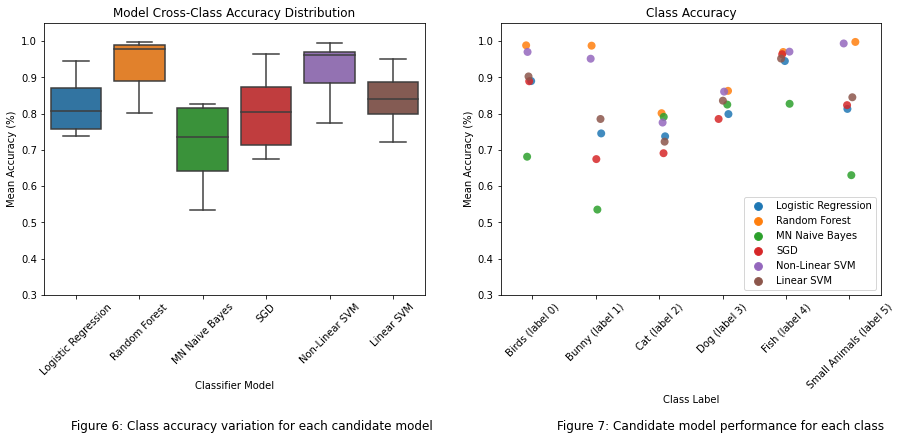

In [28]:
# Model comparison visualisation

# unpivot df for plotting
mod_unpiv= model_suite[1].melt(id_vars=['Classifier Model'],var_name='Class Label',value_name='Accuracy')

# plot
fig, ax =plt.subplots(1,2,figsize=(15,5))

# model performance across classes
plt.subplot(1, 2, 1) # row 1, col 2 index 1
sns.boxplot(x='Classifier Model',y='Accuracy',data=mod_unpiv)
plt.xticks(rotation=45)
plt.xlabel('Classifier Model')
plt.ylim(0.3,1.05)
plt.ylabel('Mean Accuracy (%)')
plt.title('Model Cross-Class Accuracy Distribution')
plt.figtext(0.15,-0.25,'Figure 6: Class accuracy variation for each candidate model',fontsize=12)

# model performance in Class
plt.subplot(1, 2, 2) # index 2
# replaced catplot to stripplot and removed kind='swarm'. Catplot does not work within subplot
sns.stripplot(x='Class Label',y='Accuracy',hue='Classifier Model',palette = 'tab10',data=mod_unpiv,alpha=0.85 ,s=8)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.ylim(0.3,1.05)
plt.ylabel('Mean Accuracy (%)')
plt.title('Class Accuracy')
plt.figtext(0.6,-0.25,'Figure 7: Candidate model performance for each class',fontsize=12)


## Candidate Model Selection
#### Random Forest and Non-Linear (RBF kernel) SVM classifiers are the most performant and will be considered for final model evaluation. 

Both non-linear classifiers achieve significantly greater evaluation metric scores in comparison to competing linear models. Accuracy increases +7.5% in comparison to the best competitor model, whilst F1 improves +10%. Furthermore, mean Accuracy distribution across individual classes indicates that both of these models minimise deviation well between classes. In addition, in-class accuracy indicates that boundaries between classes have been established, with leading classifier scores for each class. 

Across all models, minority class accuracy has improved in contrast to the baseline, suggesting that oversampling has been effective. However, a particular consideration for Random Forest and Non-Linear SVM is the very high accuracy scores for oversampled minority classes. This could be indicative of over-fitting to the training data. However, with limited training data available for use, this will have to be determined following testing upon unseen data. 



# Hyper-Parameterisation Pipeline
Parameter optimisation can further develop the predictive capabilities of the two best candidate models. This process iterates through different classifier hyper-parameters, the object being to identify optimal combinations, which minimises training loss and enhance the model’s ability to generalise class data patterns and determine decision boundaries; solving this PoC’s specific classification problem. For the purposes of this PoC, accuracy will be the target metric, with each classifier learning how to maximise the classification rate within cross-validation of the training data (Claesen and De Moor, 2015). 

Exhaustive Grid Search (Pedregosa et al., 2011) is the typical process used, systematically comparing each parameter combination specified within the parameter grid. Whilst thorough, there are significant performance drawbacks, especially as parameter combinations increase, limiting feasibility. This was a particular concern within the PoC given the search space not only included classifier parameters, but using a pipeline, also sought to optimise TF-IDF features and reduce high dimensionality data to improve classifier performance (Bengfort, Bilbro and Ojeda, 2018; Lee, 2020). With 700 parameter combinations (SVM) and computational expensive pipeline processes, each repeated for the 3,500 fits occurring within the 5-fold cross validation. The limited computational resources available to this PoC would be unsuitable to perform this task. 

To mitigate these performance costs, Randomised Search was used, limiting total fits per fold to 10 randomly selected parameter combinations. Whilst, not exhaustive, Bergstra and Bengio (2012) found that performance was more effective at reaching equal performance to grid search, in some cases even out-performing, especially in cases of low effective parameter dimensionality. Furthermore, accelerated fit times enabled further search iteration to manually fine-tune parameter distributions to quickly identify optimal parameters.


In [ ]:
# Random Forest Parameterisation

# Pipeline
model = make_pipeline(TfidfVectorizer(),
                              SMOTE(),
                              TruncatedSVD(),
                              MinMaxScaler(),
                              RandomForestClassifier()
                              )

imba_param = {'tfidfvectorizer__ngram_range':[(1,1),(1,2)], #unigrams or unigrams and bigrams
              'tfidfvectorizer__max_df':[0.95,1.0], # max documents to include corpus. where in 95% of texts or word in 100%
              'tfidfvectorizer__min_df':[1,3,5], # min docs a word has to be in
              'smote__sampling_strategy':['not majority'], # based on previous iteration
              'smote__random_state':[10],
              'truncatedsvd__n_components':[100], # 100 based on previous iteration
              'randomforestclassifier__max_depth':[10,100],
              'randomforestclassifier__n_estimators':[50,100,1000],
              'randomforestclassifier__min_samples_leaf':[1,2,4],
              'randomforestclassifier__max_features':['auto','sqrt'],
              'randomforestclassifier__random_state':[10]
              'randomforestclassifier__n_jobs':[-1]
              }

# fitting pipeline
model.fit(clean_review_train,y_train)


# 5 fold randomised search (performance benefits over grid search)
rdgrid = RandomizedSearchCV(estimator=model,param_distributions=imba_param,cv=5,scoring='accuracy',verbose=1)

bst_rf_rdCV = rdgrid.fit(clean_review_train,y_train)

# search outcomes (Completed on alternative Google Colab TPU)
print(bst_rf_rdCV.best_score_)
print(bst_rf_rdCV.best_params_) 
# if running on powerful machine, use the best_params_ attribute directly as fitted model

bst_rf_rdCV.cv_results_

# best params (Google Colab TPU): ngram(1,1),min_df(1), max_df(0.95),n_estimators(1000),min_samples_leaf(1), 
# max_features(auto),max_depth(100)


In [9]:
# Non-Linear SVM Parameterisation

# Pipeline
model = make_pipeline(TfidfVectorizer(),
                        SMOTE(),
                        TruncatedSVD(),
                        MinMaxScaler(),
                        SVC()
                     )


parameters = {'tfidfvectorizer__min_df':[1,3,5],
              'tfidfvectorizer__ngram_range':[(1,1),(1,2)],
              'tfidfvectorizer__max_df':[0.95,1.0],
              'smote__sampling_strategy':['not majority'],
              'truncatedsvd__n_components':[100], # 100 components determined in earlier process
              'svc__C':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10],
              'svc__gamma':[0.1,1,2,3,4,5,10],
              'svc__kernel':['rbf'], # non-linear SVM determined during initial model selection
              'svc__random_state':[10],
              'svc__max_iter':[10000] # control processing time
              }

model.fit(clean_review_train,y_train)  

# randomizedSearchCV performance benefits over GridSearch
rdgrid = RandomizedSearchCV(estimator=model,param_distributions=parameters,scoring='accuracy',cv=5,verbose=1)


# search outcomes (Completed externally on Google Colab TPU)
bst_svm_rdCV = rdgrid.fit(clean_review_train,y_train) 
print(bst_svm_rdCV.best_params_) 
# if running on powerful machine, use the best_params_ attribute directly as fitted model

print(bst_svm_rdCV.best_score_)
bst_svm_rdCV.cv_results_


# best params (Google Colab TPU): ngram(1,2),min_df(3), max_df(0.95),kernel(RBF),gamma(4),C(1)


In [29]:
# best models (output from best_params_ model attribute)

best_rf = RandomForestClassifier(random_state = 10,
                                 n_estimators=1000,
                                 min_samples_leaf=1,
                                 max_features='auto',
                                 max_depth=100)


best_svm = SVC(kernel='rbf',
               random_state=10,
               gamma=4,
               C=1,
               max_iter=10000,
               probability=True) # param needed for precision-recall curve


## Parameter Tuning Summary

Computational requirements were significant, requiring long time frames to complete. Each candidate model preferred different ngram ranges. SVM incorporated both unigrams and bigrams, whilst Random Forest used only unigrams, improving data parsimony.

User experience prolonged fit times as initial starting parameter range industry standards were unknown. However, using the fit '.cv_results_' attribute to investigate parameter selection for initial 10 combinations, parameter ranges were finetuned, with subsequent searches better targetting more performant parameter ranges. 


# Model Evaluation (Testing Data)
The best two candidate models, each tuned to best optimise predictive results upon the training data will now be evaluated using the 20% of original data which has remained unseen throughout model development. The ability for each candidate model to generalise training data learning to this test data will determine which is the most effective predictive classifier, and the best model to be used within the scope of this PoC and for future application on new data.

Furthermore, performance will be compared to initial baseline performance, which used no parameterisation or resampling to determine benefits provided through end-to-end processing.


Evaluation will analyse performance of:
-	Classification Report detailing aggregate and class metrics
-	Confusion matrices (scores normalised to record recall, given importance of true class allocation and to improve readability of this imbalanced test data)
-	Precision-Recall Curve (PRC) to measure relationship between two corresponding metrics
-   Usability (e.g. processing time)

PRC has been preferred to the more common Receiver Operating Characteristic (ROC) curve because the nature of these models concerns significantly imbalanced class distribution (Davis and Goadrich, 2006). Performance over-optimism can occur with ROC curves due to inclusion of False Positive Rate. PRC mitigates this, instead measuring True Positives as a fraction of all positive predictions (Saito and Rehmsmeier, 2015; Brownlee, 2018).


### Baseline) Naive Bayes: No Processing or Parameterisation

In [30]:
# nb confusion matrix
# create

# review data not processed or cleaned
X_train_orig
X_test_orig
y_train
y_test

nb_fit = NB.fit(X_train_orig,y_train)
nb_pred = nb_fit.predict(X_test_orig)


nb_cm = confusion_matrix(y_test,nb_pred,normalize='true').round(2)
nb_cm = pd.DataFrame(nb_cm,
                     index = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'], 
                     columns = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'])

# classification report
print(classification_report(y_test,nb_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       282
           1       0.00      0.00      0.00       152
           2       0.78      0.60      0.68      4932
           3       0.72      0.96      0.82      7467
           4       0.97      0.19      0.32       958
           5       0.00      0.00      0.00        91

    accuracy                           0.74     13882
   macro avg       0.41      0.29      0.30     13882
weighted avg       0.73      0.74      0.71     13882



### Candidate 1) Random Forest: Tuned

In [31]:
# best tfidf parameters

# random forest

# best params for rf

# tfidf
tf_idf_clean_1 = TfidfVectorizer(ngram_range = (1,1),min_df=1,max_df=0.95)

# features to use for training set
X_train_rf_params = tf_idf_clean_1.fit_transform(clean_review_train)
X_test_rf_params = tf_idf_clean_1.transform(clean_review_test)

# applying training corpus to test data
#tf_idf_clean_2 = TfidfVectorizer(vocabulary=tf_idf_clean_1.vocabulary_)

#X_test_clean = tf_idf_clean_2.fit_transform(clean_review_test)

# 11076 features
print('TFIDF X train and test: ',X_train_rf_params.shape, X_test_rf_params.shape)

# oversample training with SMOTE
X_train_rf_smt, y_train_smt = smt.fit_resample(X_train_rf_params,y_train)
print('SMOTE X and Y train: ',X_train_rf_smt.shape,y_train_smt.shape)


# dimension reduction
# feature reduction of data to 100 for train and test
svd = TruncatedSVD(n_components=100, random_state=10,n_iter=10)
svd.fit_transform(X_train_rf_smt) # fit to train

X_train_rf = svd.fit_transform(X_train_rf_smt)
X_test_rf = svd.transform(X_test_rf_params) # use train parameters on test (test remains unseen)
scaler = MinMaxScaler() # need to scale for NB use (cannot be negative)
X_train_rf = scaler.fit_transform(X_train_rf)
X_test_rf = scaler.transform(X_test_rf) #use train parameters on test (test remains unseen)

print('Dim Reduction X train and test: ',X_train_rf.shape, X_test_rf.shape)


TFIDF X train and test:  (55528, 27164) (13882, 27164)
SMOTE X and Y train:  (179196, 27164) (179196,)
Dim Reduction X train and test:  (179196, 100) (13882, 100)


In [32]:
# binarize multiclass labels for use in prec-recall curve (one-hot encoding)
classes = [0,1,2,3,4,5]
n_classes = 6
class_name = {0:'Birds',1:'Bunnny',2:'Cat',3:'Dog',4:'Fish',5:'Small Animals'}

# train and test data
y_binary_train = label_binarize(y_train_smt,classes=classes)
y_binary_test = label_binarize(y_test,classes=classes)

In [33]:
# Random Forest Model evaluation on Test Data
start = time.time()
rf_fit = best_rf.fit(X_train_rf,y_train_smt)
rf_ypred = rf_fit.predict(X_test_rf)
tm = (time.time()-start)/60/60
print('Fit time (hrs): ',tm)
# classification report
print(classification_report(y_test,rf_ypred))


Fit time (hrs):  0.6130183683501349
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       282
           1       0.52      0.66      0.58       152
           2       0.81      0.73      0.77      4932
           3       0.83      0.88      0.85      7467
           4       0.82      0.86      0.84       958
           5       0.62      0.40      0.48        91

    accuracy                           0.82     13882
   macro avg       0.73      0.72      0.72     13882
weighted avg       0.82      0.82      0.82     13882



In [34]:
#f1
rf_f = f1_score(y_test,rf_ypred,average='macro').round(2)
print('Random Forest F1 Score: ',rf_f)
# rf confusion matrix
rf_cm = confusion_matrix(y_test,rf_ypred,normalize='pred').round(2)
rf_cm = pd.DataFrame(rf_cm,
                     index = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'], 
                     columns = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'])



Random Forest F1 Score:  0.72


In [35]:
# fit and predict RF
start = time.time()
rf_classifier = OneVsRestClassifier(best_rf) # takes long time, refrain from rerunning

# predict_proba for binary classification
rf_score = rf_classifier.fit(X_train_rf, y_binary_train).predict_proba(X_test_rf) 
tm = (time.time()-start)/60/60
print('Fit/ score time (hrs): ',tm)


Fit/ score time (hrs):  3.853837851087252


In [36]:
joblib.dump(rf_score,'rf_final.pkl')


['rf_final.pkl']

In [37]:
#RF: Visualise evaluation

# CM
# pred normalise = Correct/ total label predictions (recall)
rf_cm = confusion_matrix(y_test,rf_ypred,normalize='true').round(2) 
rf_cm = pd.DataFrame(rf_cm,
                     index = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'], 
                     columns = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'])

# PR curve
precision = dict()
recall = dict()



### Candidate 2) Non-Linear SVM: Tuned

In [38]:
# best tfidf parameters

# non-linear svm

# best params for svm

# tfidf
tf_idf_clean_1 = TfidfVectorizer(ngram_range = (1,2),min_df=3,max_df=0.95) # 146459 features generated

# features to use for training set
X_train_svm_params = tf_idf_clean_1.fit_transform(clean_review_train)
X_test_svm_params = tf_idf_clean_1.transform(clean_review_test)


# 11076 features
print('TFIDF X train and test: ',X_train_svm_params.shape, X_test_svm_params.shape)

# oversample training with SMOTE
X_train_svm_smt, y_train_smt = smt.fit_resample(X_train_svm_params,y_train)
print('SMOTE X and Y train: ',X_train_svm_smt.shape,y_train_smt.shape)


# dimension reduction
# feature reduction of data to 100 for train and test
svd = TruncatedSVD(n_components=100, random_state=10,n_iter=10)
svd.fit_transform(X_train_svm_smt) # fit to train

X_train_svm = svd.fit_transform(X_train_svm_smt)
X_test_svm = svd.transform(X_test_svm_params) # use train parameters on test (test remains unseen)
scaler = MinMaxScaler() # need to scale for NB use (cannot be negative)
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm) #use train parameters on test (test remains unseen)

print('Dim Reduction X train and test: ',X_train_svm.shape, X_test_svm.shape)


TFIDF X train and test:  (55528, 146459) (13882, 146459)
SMOTE X and Y train:  (179196, 146459) (179196,)
Dim Reduction X train and test:  (179196, 100) (13882, 100)


In [39]:
# SVM evaluation on Test Data

start = time.time()
svm_fit = best_svm.fit(X_train_svm,y_train_smt)# refrain from rerunning
svm_ypred = svm_fit.predict(X_test_svm)
end = time.time()
fit_time = ((end-start)/60)/60 #hours
print('Fitting Time (hr): ',fit_time,'\n')
svm_cm = confusion_matrix(y_test,svm_ypred)
# print(svm_cm)

print(classification_report(y_test,svm_ypred))


Fitting Time (hr):  1.9658180791801876 

              precision    recall  f1-score   support

           0       0.67      0.77      0.72       282
           1       0.53      0.61      0.57       152
           2       0.85      0.71      0.77      4932
           3       0.82      0.90      0.86      7467
           4       0.79      0.86      0.82       958
           5       0.54      0.32      0.40        91

    accuracy                           0.82     13882
   macro avg       0.70      0.70      0.69     13882
weighted avg       0.82      0.82      0.82     13882



In [40]:
#f1
svm_f = f1_score(y_test,svm_ypred,average='macro').round(2)
print('SVM F1 Score: ',svm_f)

# svm confusion matrix
svm_cm = confusion_matrix(y_test,svm_ypred,normalize='pred').round(2)
svm_cm = pd.DataFrame(svm_cm,
                     index = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'], 
                     columns = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'])

SVM F1 Score:  0.69


In [41]:
# fit and predict SVM - binary
start = time.time()
svm_classifier = OneVsRestClassifier(best_svm) # refrain from rerunning - takes long time
svm_score = svm_classifier.fit(X_train_svm, y_binary_train).predict_proba(X_test_svm)
end = time.time()
fit_time = (end-start)/60/60
print('Time to fit and predict (hrs): ',fit_time)


Time to fit and predict (hrs):  4.276826358040173


In [42]:
joblib.dump(svm_score,'svm_final.pkl')


['svm_final.pkl']

In [43]:
#SVM: Visualise evaluation

# CM
svm_cm = confusion_matrix(y_test,svm_ypred,normalize='true').round(2) # pred normalise = Correct/ tot lab predictions
svm_cm = pd.DataFrame(svm_cm,
                     index = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'], 
                     columns = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'])

# PR curve
precision_svm = dict()
recall_svm = dict()


## Model Evaluation
### Visualisation

In [44]:
# evaluation summary table

mod_dict = {'Baseline Naive Bayes':nb_pred,'Random Forest':rf_ypred,'SVM':svm_ypred}

def eval_model(dict,ytest):
    name,acc,prec,rec,f1 = [],[],[],[],[]
    for n,p in dict.items():
        name.append(n)
        acc.append(accuracy_score(ytest,p))
        prec.append(precision_score(y_test,p,average='macro'))
        rec.append(recall_score(y_test,p,average='macro'))
        f1.append(f1_score(y_test,p,average='macro'))
    
    df = pd.DataFrame([name,acc,prec,rec,f1]
                     ).T.sort_values(by=4,ascending=False
                                    ).rename(columns={0:'Model',1:'Accuracy',2:'Precision',3:'Recall',4:'F1'})
    return df

print('Model Evaluation Summary')
eval_model(mod_dict,y_test)


Model Evaluation Summary


,Model,Accuracy,Precision,Recall,F1
1,Random Forest,0.817317,0.726414,0.718546,0.716443
2,SVM,0.819983,0.700941,0.695924,0.691271
0,Baseline Naive Bayes,0.7424,0.412779,0.29172,0.303678


Text(0.15, 0.8, 'F1 Score:  Baseline 0.30; RF 0.72; SVM 0.69')

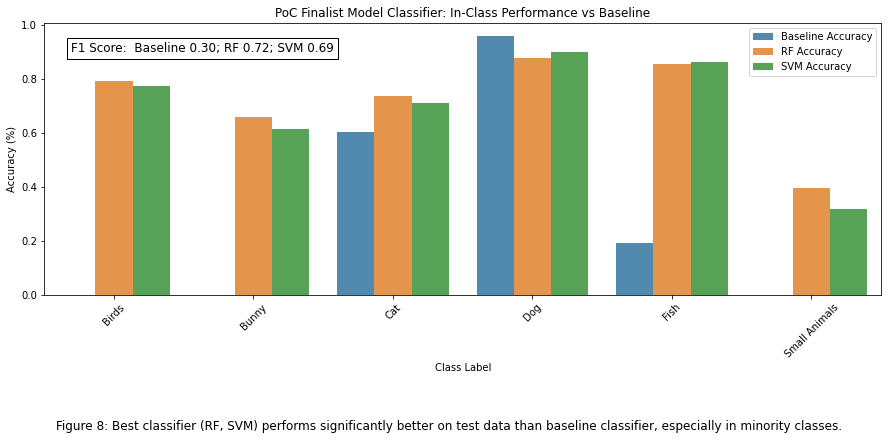

In [78]:
# Model evaluation - class accuracy

nb_cm_bar = confusion_matrix(y_test,nb_pred).round(2)
nb_class_acc = nb_cm_bar.diagonal()/nb_cm_bar.sum(axis=1)

rf_cm_bar = confusion_matrix(y_test,rf_ypred).round(2)
rf_class_acc = rf_cm_bar.diagonal()/rf_cm_bar.sum(axis=1)

svm_cm_bar = confusion_matrix(y_test,svm_ypred).round(2)
svm_class_acc = svm_cm_bar.diagonal()/svm_cm_bar.sum(axis=1)

labs = ['Birds','Bunny','Cat','Dog','Fish','Small Animals']
final_model_improv = pd.DataFrame([labs,nb_class_acc,rf_class_acc,svm_class_acc]
                                 ).T.rename(columns={0:'Class Label',1:'Baseline Accuracy', 2: 'RF Accuracy',
                                                     3:'SVM Accuracy'})

model_improv_unpiv = pd.melt(final_model_improv,id_vars='Class Label',
                             value_name='Accuracy',var_name = 'Classifier Model')


fig, ax =plt.subplots(1,1,figsize=(15,5))

sns.barplot(data=model_improv_unpiv,x='Class Label',y='Accuracy',
              hue='Classifier Model',palette = 'tab10',alpha=0.85)#,palette=['darkorange','purple'])
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.ylabel('Accuracy (%)')
plt.title('PoC Finalist Model Classifier: In-Class Performance vs Baseline')
plt.figtext(
    0.5,-0.25,
    'Figure 8: Best classifier (RF, SVM) performs significantly better on test data than baseline classifier, especially in minority classes.',
    horizontalalignment='center',
    fontsize=12
)
plt.figtext(
    0.15,.8,
    'F1 Score:  Baseline 0.30; RF 0.72; SVM 0.69',
    fontsize=12,
    bbox=dict(facecolor='none', edgecolor='black'))


Text(0.2, -0.05, 'Figure 9: NB Baseline performance on unseen test data')

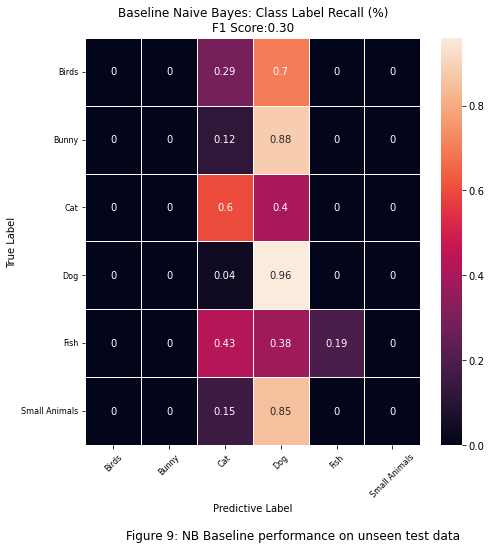

In [51]:
#confusion matrix (normalised for pred accuracy)
# baseline NB
fig, ax =plt.subplots(1,1,figsize=(7.5,7.5))

#f1
nb_f = f1_score(y_test,nb_pred,average='macro').round(2)

#confusion matrix (normalised for pred accuracy)
plt.subplot(1, 1, 1) # plot 1
sns.heatmap(nb_cm,annot=True,fmt='g',linewidth=0.5) 
plt.title('Baseline Naive Bayes: Class Label Recall (%)\nF1 Score:{0:.2f}'.format(nb_f))
plt.xlabel('Predictive Label', fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.yticks(rotation=0,fontsize=8)
plt.xticks(rotation=45,fontsize=8)
plt.figtext(0.2,-0.05,'Figure 9: NB Baseline performance on unseen test data',fontsize=12)




Candidate Model Evaluation: 



Text(0.15, 0.001, 'Figure 10: Candidate Model evaluation considers Accuracy, Precision, Recall and F1 scores to determine the best predictive classifier')

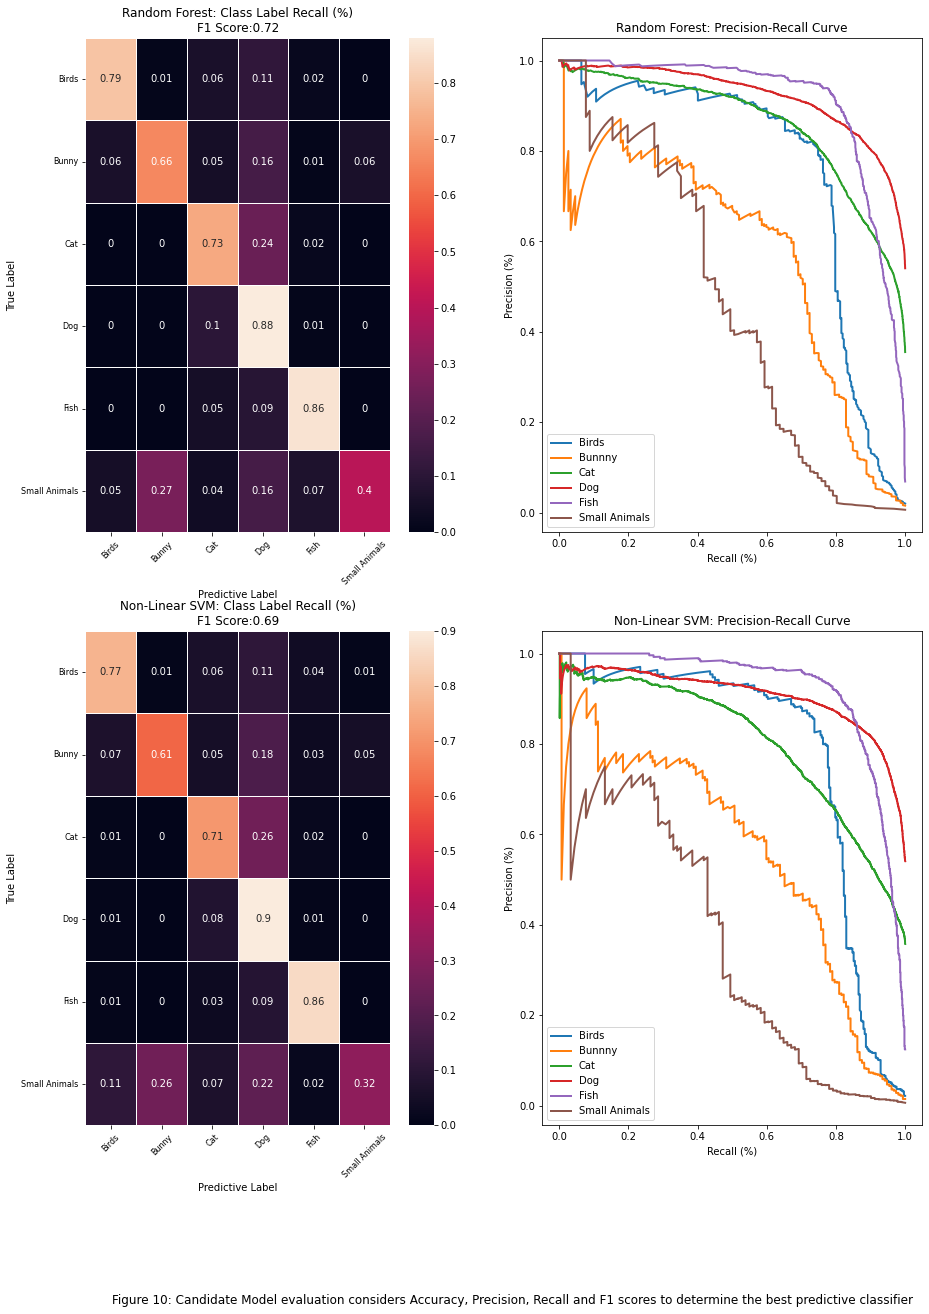

In [77]:
# Classifier Evaluation - Visualisation
# Confusion Matrix comparison (Normalised - True (Recall))
# Precision-Recall Curve


fig, ax =plt.subplots(2,2,figsize=(15,20))

print('\n\nCandidate Model Evaluation: \n')
# rf
plt.subplot(2, 2, 1) # plot 1
sns.heatmap(rf_cm,annot=True,fmt='g',linewidth=0.5) 
plt.title('Random Forest: Class Label Recall (%)\nF1 Score:{0:.2f}'.format(rf_f))
plt.xlabel('Predictive Label', fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.yticks(rotation=0,fontsize=8)
plt.xticks(rotation=45,fontsize=8)


plt.subplot(2,2, 2) # plot 2
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_binary_test[:, i],
                                                        rf_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=class_name[i])
 
 
plt.xlabel('Recall (%)',fontsize=10)
plt.ylabel('Precision (%)',fontsize=10)
plt.legend(loc="best")
plt.title("Random Forest: Precision-Recall Curve")

# svm
plt.subplot(2,2,3) # plot 3
sns.heatmap(svm_cm,annot=True,fmt='g',linewidth=0.5) 
plt.title('Non-Linear SVM: Class Label Recall (%)\nF1 Score:{0:.2f}'.format(svm_f))
plt.xlabel('Predictive Label', fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.yticks(rotation=0,fontsize=8)
plt.xticks(rotation=45,fontsize=8)

plt.subplot(2,2, 4) # plot 3
for i in range(n_classes):
    precision_svm[i], recall_svm[i], _ = precision_recall_curve(y_binary_test[:, i],
                                                        svm_score[:, i])
    plt.plot(recall_svm[i], precision_svm[i], lw=2, label=class_name[i])
 
 
plt.xlabel('Recall (%)',fontsize=10)
plt.ylabel('Precision (%)',fontsize=10)
plt.legend(loc="best")
plt.title('Non-Linear SVM: Precision-Recall Curve')
plt.figtext(0.15,.001,
            'Figure 10: Candidate Model evaluation considers Accuracy, Precision, Recall and F1 scores to determine the best predictive classifier',
            fontsize=12)



## Evaluation Summary 

The two best performing, tuned candidate classifiers have been evaluated and compared against the initial baseline Naive Bayes to establish potential benefits gained by text processing and parameterisation within this PoC. Evaluation considers overall F1, accuracy, precision and recall scores alongside in-class performance and is summarised within the evaluation table. 

Performance across each metric for the candidate classifiers is superior to the baseline, in particular, F1 scores, resulting from recall differences. Significant class imbalance alongside lack of parameterisation prevents equal in-class predictive performance (Figure 8). This is especially apparent in Figure 9, which normalises baseline test prediction confusion matrix to provide recall. Prevalent classification for each label prediction is for the majority classes (Dog or Cat) due to predominance within training data. Recall for each minority class is 0%, with the exception of Fish, scoring 19% recall, despite 3,831 training documents.

Accuracy increases for both candidate classifiers from the baseline of 74% to 82%. Furthermore, significant improvements to precision and recall scores indicate that both False Negatives are False Positives have reduced at a consistent rate (False Negative reduction a particular development priority given initial label imbalance). As demonstrated within Figure 10's Confusion Matrices, True Positives for each class now form the majority prediction for each true class. In particular, Classification reports indicate Fish class recall increases significantly, from 21% to 86% (both candidates), implying that processing and modelling has supported in-class performance improvement, despite original small number of training documents available (pre-SMOTE). However, it should be noted that in comparison to initial majority class performance, accuracy scores remain depressed, indicating that limited corpus sizes do influence model performance, despite process and model improvements.

F1 scores increase to 72% and 69% for Random Forest and SVM respectively, which indicates a much improved and balanced predictive performance between effective precision and recall. Figure 10 comparison determines that Random Forest more effectively predicts most classes, including all minority classes. Despite SVM scoring +2% recall within majority Dog class reviews, significance of this result is limited due to the high scores recorded for both classifiers (90% and 88% respectively). This is supported by Precision-Recall Curves, where Random Forest trends towards optimal co-ordinates for more classes, in particular for Small Animal and Bunny.

Thorough Evaluation of both candidate classifiers indicates that despite fewer initial features pre-feature-reduction (27,164 to 146,459 corpus entries) Random Forest performs better at generalising training data to unseen data and making more accurate predictions for each Class Label. Improved ability to successfully recall each true class is fundamental due to the equal importance assigned to each label, despite the imbalanced nature of the original dataset. Furthermore, in comparison to SVM, fit and predict model processing time is faster. Random Forest completing in 37 minutes (3.2 times faster than SVM). A trait highly beneficial within revenue-driven organisations like LifeInsurer.

Overall, model performance indicates that the Random Forest Classifier is the most effective candidate model and will be used on future review datasets to provide product classification as part of PoC scope.


# Conclusion and Summary
### PoC Development

Development of a multi-class predictive classifier to categorise textual data has been successful. Effective text processing and feature engineering, combined with robust model evaluation have delivered significant performance improvements in contrast to baseline classification. Minority class accuracy has improved despite highly imbalanced source data limiting minority class corpus size and differentiating vocabulary. In part, this has been mitigated by synthesising artificial documents which represent class instances using SMOTE, however, with such a limited training corpus, barriers will persist in achieving superior classification scores.

Additional labelled data would significantly improve existing classification scores by increasing vocabulary variation and total corpus size to distinguish classes. In particular, this would support improved differentiation Bunny from Small Animal documents, due to inherent similarities within existing vocabulary and Small Animal aggregation of sub-animals, including rabbits. Whilst unable to provide additional domain knowledge in scope of this PoC data, applied to LifeInsurer’s customer data, class allocation can be effectively planned, mitigating the structural errors which promote these issues, ensuring that class overlap is controlled and label granularity is comparable.

A key limitation of this PoC has been the lack of dedicated computational resource, leading the author to compromise and split PoC development between local and cloud-based (TPU) resources (Google Colaboratory, 2021). Whilst this supported specific computationally expensive tasks such as data pipeline fitting and parameter search, connection inconsistency and session time-outs resulted in loss of saved variables from respective model RandomisedSearchCV. Locally, the author successfully used pickling as a method to reduce expensive task repetition (Izadi, 2020). However, the author experienced .pkl object transfer issues between Colab and local environments; preventing this strategy for Colab-generated objects, and therefore, direct use of ‘.best_params_ ‘ search attributes to directly predict from the object; adding additional manual stages to the PoC. 

Furthermore, with a 12 hour session limit, certain stages were optimised outside of the search pipeline, including resampling approach and LSA component number. Inclusion within pipeline would have increased fit complexity; potentially preventing search completion, increasing risk of completion failure and resultant loss of time.  Therefore, whilst independent efforts have been made to identify optimal combinations of approaches and parameters outside of search parameters, integration within search pipeline could have yielded alternative solutions.

In addition, whilst Deep Learning methods have purposefully been excluded from this PoC due to expected technical and organisational restrictions at LifeInsurer, future iterations should consider Neural Network classifiers such as LSTM. Across high dimensionality data, such as that found within textual data, predictive performance could significantly improve (Pal, Ghosh and Nag, 2018; Kindbom, 2019). A basic framework has been developed in Appendix-1 to support these future efforts using a BOW approach.  



### Reflection

PoC development has delivered substantial personal and professional growth, not least that like in the real-world, compromise must be made between optimal, process plans and what is achievable within a given resource and timeline constraints. Encountering and overcoming issues throughout the PoC development cycle (Kolb, 1984) illustrated how engaging with literature, online forums, industry application and problem-solving are critical to self-improvement, and as a result drove successful delivery of the PoC best predictive model.

Pre-determined stages such as planned LSA reduction to 1,000 components may have delivered increased accuracy benefits following research, however, after encountering substantial processing times alongside a wider investigation into accuracy yield at different component numbers, 100 was selected; providing the best compromise between scoring and computational performance. Combined with resampling of training data, dimensionality of final training data escalated significantly. Future PoC will learn from this. For example, whilst resampling approaches measured accuracy, generation time was not considered. Combination of different undersampling and oversampling techniques should be pursued. In retrospect, whilst SMOTE was effective, minority class oversampling by a ratio of 1:81 could be investigated further, given the significant increase to training data dimensionality. Outside the academic scope of the PoC, within LifeInsurer’s development teams, resources such as time are highly valuable, given the revenue and customer-driven nature of a real-world business model. The impracticality of exceptional fit and prediction times at LifeInsurer would deter widespread usage and could dissuade additional ML activity.

Fortunately, PoC has always been considered within the scope of application by LifeInsurer. Therefore, resource mitigation, access and ease of use have been considered throughout the process. Use of this PoC framework on LifeInsurer customer contact data should deliver significant resource and accuracy benefits, releasing human resource from monotonous task completion. Furthermore, successful, real examples of ML application such as the text classification in this PoC could drive increased ML familiarisation and usage across the organisation. Downstream, this could lead to additional automative classification, and places LifeInsurer in a strong position to directly engage with and utilise the increasing volumes unstructured data; helping to shape the products and services of an increasingly digitalised customer-base.


# References
Adnan, K. and Akbar, R. (2019) ‘An analytical study of information extraction from unstructured and multidimensional big data’, Journal of Big Data, 6(1), p. 91. doi:10.1186/s40537-019-0254-8.

Amazon (2021) Amazon Customer Reviews Dataset. Available at: https://s3.amazonaws.com/amazon-reviews-pds/readme.html (Accessed: 23 June 2021).

Beel, J., Gipp, B., Langer, S. and Breitinger, C. (2016) ‘Research-paper recommender systems: a literature survey’, International Journal on Digital Libraries, 17(4), pp. 305–338. doi:10.1007/s00799-015-0156-0.

Bengfort, B., Bilbro, R. and Ojeda, T. (2018) Applied Text Analysis with Python: Enabling Language-Aware Data Products with Machine Learning. 1st edition. Sebastopol, CA: O′Reilly.

Bergstra, J. and Bengio, Y. (2012) ‘Random search for hyper-parameter optimization’, The Journal of Machine Learning Research, 13(null), pp. 281–305.

Brownlee, J. (2018) ‘How to Use ROC Curves and Precision-Recall Curves for Classification in Python’, Machine Learning Mastery, 30 August. Available at: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ (Accessed: 8 January 2022).

Claesen, M. and De Moor, B. (2015) ‘Hyperparameter Search in Machine Learning’, arXiv:1502.02127 [cs, stat] [Preprint]. Available at: http://arxiv.org/abs/1502.02127 (Accessed: 4 January 2022).

Davis, J. and Goadrich, M. (2006) ‘The relationship between Precision-Recall and ROC curves’, in Proceedings of the 23rd international conference on Machine learning. New York, NY, USA: Association for Computing Machinery (ICML ’06), pp. 233–240. doi:10.1145/1143844.1143874.

Gantz, J. and Reinsel, D. (2012) The Digital Universe in 2020: Big Data, Bigger Digital Shadows, and Biggest Growth in the Far East. Available at: https://www.emc.com/leadership/digital-universe/2012iview/index.htm (Accessed: 24 February 2021).

Google Colaboratory (2021). Available at: https://colab.research.google.com/notebooks/ (Accessed: 5 January 2022).

Izadi, M. (2020) ‘Pickle your model in Python’, Medium, 6 January. Available at: https://medium.com/@maziarizadi/pickle-your-model-in-python-2bbe7dba2bbb (Accessed: 17 January 2022).

Kaggle (2021) Amazon pet product reviews classification. Available at: https://kaggle.com/c/amazon-pet-product-reviews-classification (Accessed: 30 December 2021).

Kindbom, H. (2019) ‘LSTM vs Random Forest for Binary Classification of Insurance Related Text’, Royal Institute of Technology School of Engineering Sciences, p. 75.

Kolb, D. (1984) Experiential Learning: Experience As The Source Of Learning And Development, Journal of Business Ethics.

Korzycki, M., Gatkowska, I. and Lubaszewski, W. (2017) ‘2 - Can the Human Association Norm Evaluate Machine-Made Association Lists?’, in Sharp, B., Sèdes, F., and Lubaszewski, W. (eds) Cognitive Approach to Natural Language Processing. Elsevier, pp. 21–40. doi:10.1016/B978-1-78548-253-3.50002-0.

Lee, J. (2020) Text Feature Extraction With Scikit-Learn Pipeline, Medium. Available at: https://towardsdatascience.com/the-triune-pipeline-for-three-major-transformers-in-nlp-18c14e20530 (Accessed: 4 January 2022).

Li, S. (2019) Multi-Class Text Classification with LSTM, Medium. Available at: https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17 (Accessed: 11 January 2022)

Maheshwari, A. (2021) Data Analytics Made Accessible: 2021 edition.

Malhotra, R. and Sharma, S. (2018) Machine Learning in Insurance: Enabling insurers to become AI-driven enterprises powered by automated machine learning. Accenture. Available at: https://www.accenture.com/_acnmedia/pdf-84/accenture-machine-leaning-insurance.pdf (Accessed: 6 June 2021).

Manning, C.D., Raghavan, P. and Schütze, H. (2008) Introduction to Information Retrieval. Cambridge: Cambridge University Press. doi:10.1017/CBO9780511809071.

Nadkarni, S. and Prügl, R. (2020) ‘Digital transformation: a review, synthesis and opportunities for future research’, Management Review Quarterly [Preprint]. doi:10.1007/s11301-020-00185-7.

Nair, S. (2020) Multi Label Classification using Bag-of-Words (BoW) and TF-IDF, Medium. Available at: https://towardsdatascience.com/multi-label-classification-using-bag-of-words-bow-and-tf-idf-4f95858740e5 (Accessed: 6 January 2022).

Pal, S., Ghosh, S. and Nag, A. (2018) ‘Sentiment Analysis in the Light of LSTM Recurrent Neural Networks’, International Journal of Synthetic Emotions, 9, pp. 33–39. doi:10.4018/IJSE.2018010103.

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M. and Duchesnay, É. (2011) ‘Scikit-learn: Machine Learning in Python’, Journal of Machine Learning Research, 12(85), pp. 2825–2830.

Qaiser, S. and Ali, R. (2018) ‘Text Mining: Use of TF-IDF to Examine the Relevance of Words to Documents’, International Journal of Computer Applications, 181. doi:10.5120/ijca2018917395.

Saito, T. and Rehmsmeier, M. (2015) ‘The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets’, PLoS ONE, 10(3), p. e0118432. doi:10.1371/journal.pone.0118432.
Sarker, I.H. (2021) ‘Machine Learning: Algorithms, Real-World Applications and Research Directions’, SN Computer Science, 2(3), p. 160. doi:10.1007/s42979-021-00592-x.

SciKit-Learn (2021) 2.5. Decomposing signals in components (matrix factorization problems), scikit-learn. Available at: https://scikit-learn/stable/modules/decomposition.html (Accessed: 6 January 2022).

Sivarajah, U., Kamal, M.M., Irani, Z. and Weerakkody, V. (2017) ‘Critical analysis of Big Data challenges and analytical methods’, Journal of Business Research, 70, pp. 263–286. doi:10.1016/j.jbusres.2016.08.001.



# Appendix 1

## LSTM Neural Network: Future classifier framework

In [ ]:
# LSTM framework for potential future PoC development based upon work by Li, 2019.
# note, uses Keras libraries for NN
# use cleaned, processed text


# parameters

max_words = 27000 # corpus size (ngram (1))
max_review = 200 # review length - bar chart indicates most clean review length < 200
embedding_dim = 100 # can tune further
num_lstm = 100  # can tune further

# tokenisation and cleaning or use previously cleaned data here for comparison
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['clean_review'].values)
word_index = tokenizer.word_index

# numeric tokenisation step
X = tokenizer.texts_to_sequences(df['clean_review'].values)
X = pad_sequences(X,maxlen=max_review)

# one-hot encoding
y = pd.get_dummies(df['label']).values 


# split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,stratify=y,random_state=10)


# LSTM model
model = Sequential()
model.add(Embedding(max_words,embedding_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.2)) # regularise with dropouts
model.add(LSTM(num_lstm,dropout=0.2,recurrent_dropout=0.2)) # regularise with dropouts
model.add(Dense(6,activation='softmax')) # 6 groups, softmax generates probability
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())


# NN hyper parameters
epoch = 5 #  can tune further
batch_size = 64 #  can tune further

early_Stop = EarlyStopping(monitor='val_loss',patience=3,mode='auto') # reduce unecessary time
history = model.fit(X_train, y_train, epochs = epoch, batch_size = batch_size, 
                    validation_split= 0.1, callbacks = [early_Stop])


# test
acc = model.evaluate(X_test, y_test)
print(' Test set Loss: \n{:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0].acc[1]))
print('Test Loss: ',accr[0])
print('Test Accuracy: ',accr[1])


# further visualisation and analysis is now possible to generate best predictive classifier.